In [13]:
import os
import urllib
import zipfile
import numpy as np
import pysal as ps
import scipy.spatial as spatial
import geopandas as gpd
from geopandas import GeoDataFrame
import pandas as pd
import shapely.geometry
from shapely.geometry import Point
import matplotlib as mpl
import matplotlib.path as path
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import warnings
warnings.simplefilter('ignore')
from sklearn.datasets import load_iris
from scipy import stats
from scipy.stats import shapiro
from scipy.stats import normaltest
from libpysal.weights.contiguity import Queen
from libpysal import examples
import numpy as np
import os
import splot
from pysal.explore import esda 

In [14]:
built_period = pd.read_csv( r'C:\Users\Olga\Desktop\3rdyear\SpatialDataScience\group project\data\dwelling-period-built-2015-lsoa-msoa.csv', low_memory=False)
dwelling_type = pd.read_csv( r'C:\Users\Olga\Desktop\3rdyear\SpatialDataScience\group project\data\dwelling-property-type-2015.csv', low_memory=False)
imd = pd.read_csv( r'C:\Users\Olga\Desktop\3rdyear\SpatialDataScience\group project\data\ID 2015 for London (1).csv', low_memory=False)
fuel_2011 = pd.read_csv( r'C:\Users\Olga\Desktop\3rdyear\SpatialDataScience\group project\data\fuelpoverty2011.csv', low_memory=False)
fuel_2017 = pd.read_csv( r'C:\Users\Olga\Desktop\3rdyear\SpatialDataScience\group project\data\fuelpoverty2017.csv', low_memory=False)
efficiency =  pd.read_csv( r'C:\Users\Olga\Desktop\3rdyear\SpatialDataScience\group project\data\enegy_performance_2017.csv', low_memory=False)
lsoa =  gpd.read_file( r'C:\Users\Olga\Desktop\3rdyear\SpatialDataScience\group project\LSOA_IMD\LSOA_IMD2019.shp', low_memory=False)
lsoa = lsoa[['lsoa11cd', 'geometry']]

In [25]:
imd.head()

lsoa11cd  IMD Score
0  E01000001        6.1
1  E01000002        6.3
2  E01000003       19.5
3  E01000005       26.0
4  E01032739       13.2

In [16]:
efficiency.columns

Index(['lsoa11cd', 'LSOA 2011 Name', 'LA Name', 'A', 'B', 'C', 'D', 'E', 'F',
       'G'],
      dtype='object')

In [17]:
for i in efficiency[['A', 'B', 'C', 'D', 'E', 'F','G']]:
    efficiency[i] = efficiency[i].replace("-", '0').replace(",", '').astype(float) 

In [18]:
for i in built_period[['BP_PRE_1900', 'BP_1900_1918', 'BP_1919_1929',
       'BP_1930_1939', 'BP_1945_1954', 'BP_1955_1964', 'BP_1965_1972',
       'BP_1973_1982', 'BP_1983_1992', 'BP_1993_1999', 'BP_2000_2009',
       'BP_2010_2015', 'BP_UNKNOWN', 'ALL_PROPERTIES']]:
    built_period[i] = built_period[i].replace("-", '0').str.replace(",", '').astype(int)                  
built_period['pre1900-1939(old)'] = built_period['BP_PRE_1900'] + built_period['BP_1900_1918'] + built_period['BP_1919_1929'] + built_period['BP_1930_1939'] 
built_period['1945-1982(medium)'] =  built_period['BP_1945_1954'] + built_period['BP_1955_1964'] +  built_period['BP_1965_1972'] + built_period['BP_1973_1982']
built_period['1983-2015(new)'] = built_period['BP_1983_1992'] + built_period['BP_1993_1999'] +built_period['BP_2000_2009'] + built_period['BP_2010_2015']


In [19]:
for i in fuel_2017[['2012', '2013', '2014', '2015', '2016', '2017']]:
    fuel_2017[i] =  fuel_2017[i].replace("-", '0').replace(",", '').astype(float)   

In [20]:
for i in dwelling_type[['BUNGALOW', 'FLAT_MAIS', 'HOUSE_TERRACED',
       'HOUSE_SEMI', 'HOUSE_DETACHED', 'ANNEXE', 'ALL_PROPERTIES']]:
     dwelling_type[i] =  dwelling_type[i].replace("-", '0').str.replace(",", '').astype(float)   

In [21]:
imd['IMD Score'] = imd['IMD Score'].replace("-", '0').replace(",", '').astype(float)  

In [22]:
dwelling_type['BUNGALOW&ANNEXE'] = dwelling_type['ANNEXE'] + dwelling_type['BUNGALOW']
dwelling_type['HOUSE_TERRACED&HOUSE_SEMI'] = dwelling_type['HOUSE_TERRACED'] + dwelling_type['HOUSE_SEMI']

In [23]:
df1 = dwelling_type.merge(lsoa, on = 'lsoa11cd', how = 'inner')
df2 = df1.merge(imd, on = 'lsoa11cd', how = 'inner')
df3 = df2.merge(fuel_2011, on = 'lsoa11cd', how = 'inner')
df4 = df3.merge(fuel_2017, on = 'lsoa11cd', how = 'inner')
df5 = df4.merge(built_period, on = 'lsoa11cd', how = 'inner')
df = df5.merge(efficiency, on = 'lsoa11cd', how = 'inner')


In [24]:
#df_new = df.drop(['AREA_NAME', 'LSOA 2001 Name'], axis = 1)

gdf = gpd.GeoDataFrame(df)
gdf['Labels'] = ['First Quantile' if x< 9.40  else 'Second Quantile'if 9.40<=x<11.40  else 'Third Quantile' if 11.40<=x<14.00  else 'Fourth Quantile' for x in gdf['2017']]
gdf.columns

Index(['lsoa11cd', 'AREA_NAME_x', 'BUNGALOW', 'FLAT_MAIS', 'HOUSE_TERRACED',
       'HOUSE_SEMI', 'HOUSE_DETACHED', 'ANNEXE', 'ALL_PROPERTIES_x',
       'BUNGALOW&ANNEXE', 'HOUSE_TERRACED&HOUSE_SEMI', 'geometry', 'IMD Score',
       'LSOA 2001 Name', 'LA Name_x', '2009', '2010', '2011',
       'LSOA 2011 Name_x', 'LA Name_y', '2012', '2013', '2014', '2015', '2016',
       '2017', 'AREA_NAME_y', 'BP_PRE_1900', 'BP_1900_1918', 'BP_1919_1929',
       'BP_1930_1939', 'BP_1945_1954', 'BP_1955_1964', 'BP_1965_1972',
       'BP_1973_1982', 'BP_1983_1992', 'BP_1993_1999', 'BP_2000_2009',
       'BP_2010_2015', 'BP_UNKNOWN', 'ALL_PROPERTIES_y', 'pre1900-1939(old)',
       '1945-1982(medium)', '1983-2015(new)', 'LSOA 2011 Name_y', 'LA Name',
       'A', 'B', 'C', 'D', 'E', 'F', 'G', 'Labels'],
      dtype='object')

376002
376002
376002
376002


<AxesSubplot:xlabel='2017', ylabel='Density'>

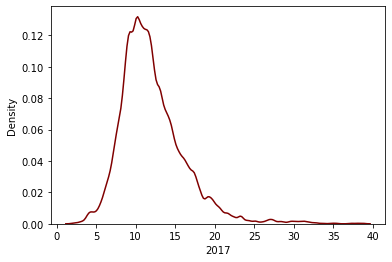

In [67]:
print(len(gdf.Labels == 'First Quantile'))
print(len(gdf.Labels == 'Second Quantile'))
print(len(gdf.Labels == 'Third Quantile'))
print(len(gdf.Labels == 'Fourth Quantile'))
sns.kdeplot(gdf['2017'],  color='maroon', label = '2017 Fuel Poverty', legend = True)

In [76]:
gdf = gdf[['lsoa11cd', 'LA Name_x','BUNGALOW&ANNEXE', 'FLAT_MAIS', 'HOUSE_TERRACED&HOUSE_SEMI', 'HOUSE_DETACHED', 'geometry', 'IMD Score', '2017', 'pre1900-1939(old)',
       '1945-1982(medium)', '1983-2015(new)', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'Labels' ]]

In [14]:
#loading gpkg file
import os
os.makedirs('data', exist_ok=True)
b_path = os.path.join('data','Boroughs.gpkg')
if not os.path.exists(b_path):
    boroughs = gpd.read_file('https://github.com/kingsgeocomp/applied_gsa/raw/master/data/Boroughs.gpkg')
    boroughs.to_file(b_path, driver='GPKG')
    print("Downloaded Boroughs.gpkg file.")
else:
    boroughs = gpd.read_file(b_path)
    print("Loaded Boroughs.gpkg file.")

Loaded Boroughs.gpkg file.


In [15]:
#gettinh the outline of all boroughs 
def plt_ldn(b=boroughs):
    fig, ax = plt.subplots(1, figsize=(14, 12))
    b.plot(ax=ax, edgecolor= '#000000', facecolor='None', zorder=3)
    ax.set_xlim([502000,563000])
    ax.set_ylim([155000,201500])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    return fig, ax


In [77]:
gdf['LA Name_x'].unique()

array(['City of London', 'Barking and Dagenham', 'Barnet', 'Bexley',
       'Brent', 'Bromley', 'Camden', 'Croydon', 'Ealing', 'Enfield',
       'Greenwich', 'Hackney', 'Hammersmith and Fulham', 'Haringey',
       'Harrow', 'Havering', 'Hillingdon', 'Hounslow', 'Islington',
       'Kensington and Chelsea', 'Kingston upon Thames', 'Lambeth',
       'Lewisham', 'Merton', 'Newham', 'Redbridge',
       'Richmond upon Thames', 'Southwark', 'Sutton', 'Tower Hamlets',
       'Waltham Forest', 'Wandsworth', 'Westminster'], dtype=object)

In [101]:
gdf_newham = gdf[(gdf['LA Name_x'] == 'Newham')]
gdf_newham.shape
gdf_merton = gdf[(gdf['LA Name_x'] == 'Merton')]
gdf_merton.shape

(10044, 20)

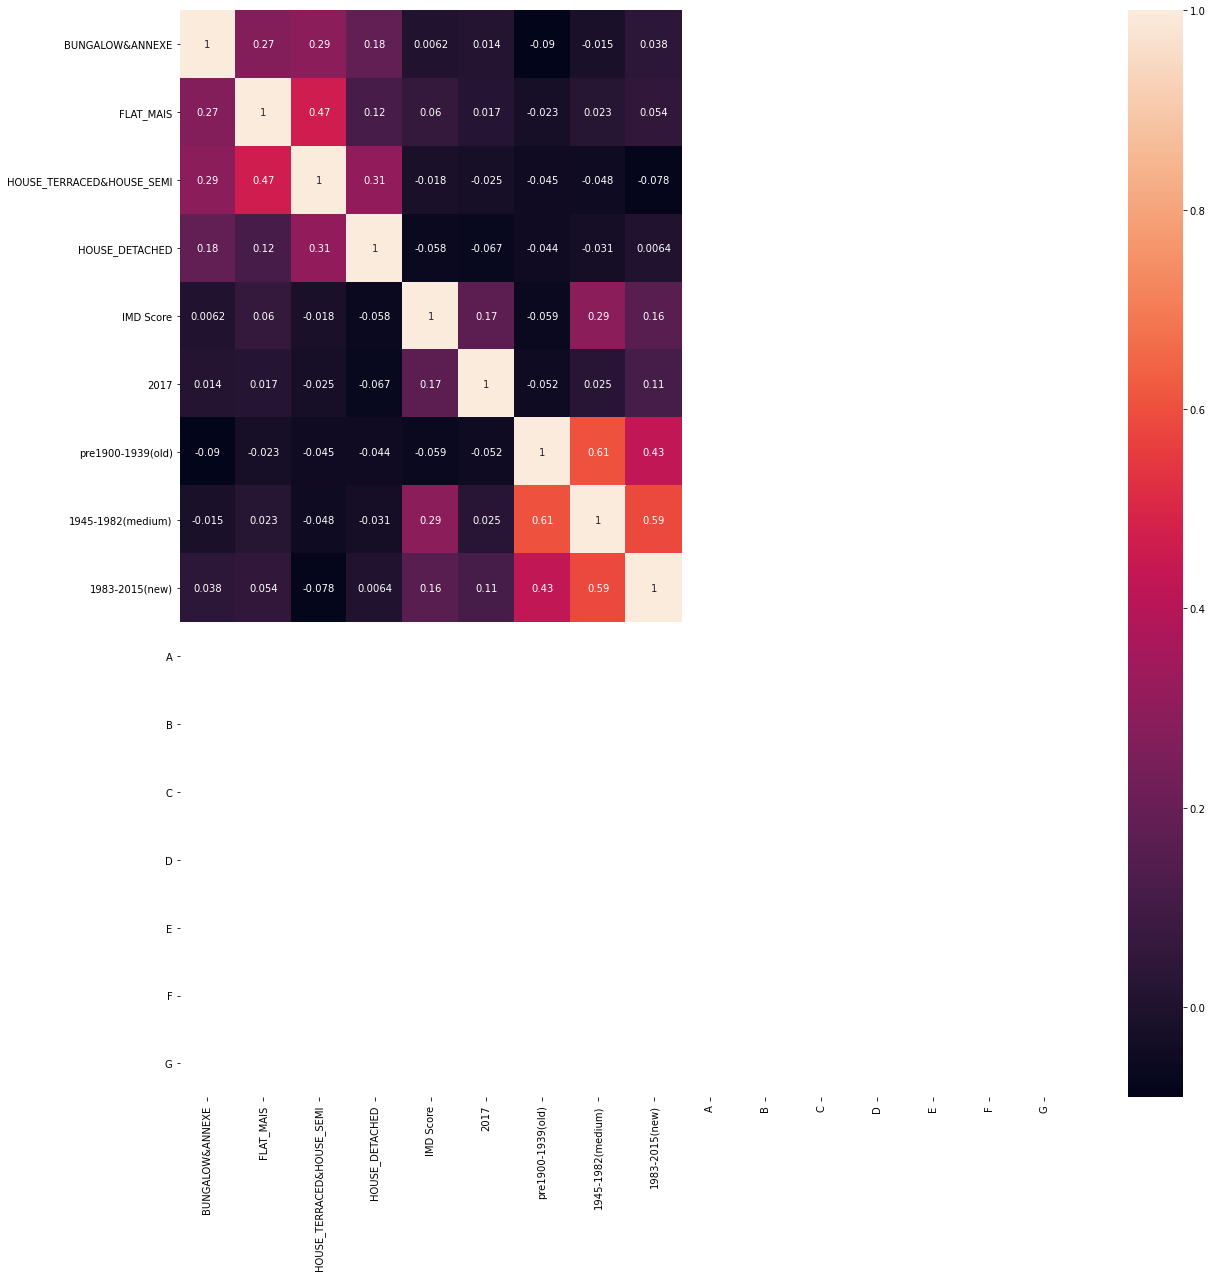

PermissionError: [Errno 13] Permission denied: 'C:\\Users\\Olga\\Desktop\\3rdyear\\SpatialDataScience\\group project\\correlation.csv'

In [156]:
fig = plt.figure(figsize=(20, 20))
corrMatrix = gdf_newham.sample(500).corr(method= 'spearman')
sns.heatmap(corrMatrix, annot=True)
plt.show()
corrMatrix.to_csv(r"C:\Users\Olga\Desktop\3rdyear\SpatialDataScience\group project\correlation.csv")

In [133]:
gdf.shape

(376002, 20)

In [155]:
from scipy import stats
print(stats.spearmanr(gdf['2017'].sample(2536), gdf['pre1900-1939(old)'].sample(2536)))
print(stats.spearmanr(gdf['2017'].sample(500), gdf['1945-1982(medium)'].sample(500)))
print(stats.spearmanr(gdf['2017'].sample(500), gdf['1983-2015(new)'].sample(500)))
print(stats.spearmanr(gdf['2017'].sample(500), gdf['A'].sample(500)))
print(stats.spearmanr(gdf['2017'].sample(500), gdf['B'].sample(500)))
print(stats.spearmanr(gdf['2017'].sample(500), gdf['C'].sample(500)))
print(stats.spearmanr(gdf['2017'].sample(500), gdf['D'].sample(500)))
print(stats.spearmanr(gdf['2017'].sample(500), gdf['E'].sample(500)))
print(stats.spearmanr(gdf['2017'].sample(500), gdf['F'].sample(500)))
print(stats.spearmanr(gdf['2017'].sample(500), gdf['G'].sample(500)))
print(stats.spearmanr(gdf['2017'].sample(500), gdf['BUNGALOW&ANNEXE'].sample(500)))
print(stats.spearmanr(gdf['2017'].sample(500), gdf['FLAT_MAIS'].sample(500)))
print(stats.spearmanr(gdf['2017'].sample(500), gdf['HOUSE_TERRACED&HOUSE_SEMI'].sample(500)))
print(stats.spearmanr(gdf['2017'].sample(500), gdf['HOUSE_DETACHED'].sample(500)))
print(stats.spearmanr(gdf['2017'].sample(500), gdf['IMD Score' ].sample(500)))

SpearmanrResult(correlation=-0.011191372817620171, pvalue=0.5732150136238803)
SpearmanrResult(correlation=-0.06993171723776453, pvalue=0.11835411713360697)
SpearmanrResult(correlation=0.03269784132065646, pvalue=0.4656890985681865)
SpearmanrResult(correlation=-0.019432122172799805, pvalue=0.6646741896290809)
SpearmanrResult(correlation=-0.01026071043603237, pvalue=0.8189713314239357)
SpearmanrResult(correlation=0.09243164226598956, pvalue=0.0388203543476273)
SpearmanrResult(correlation=0.06359210692131619, pvalue=0.15565394164431334)
SpearmanrResult(correlation=-0.018181208033293608, pvalue=0.6850658045000091)
SpearmanrResult(correlation=-0.024260739979797788, pvalue=0.5883638642872577)
SpearmanrResult(correlation=0.04248322148032296, pvalue=0.343127350402608)
SpearmanrResult(correlation=-0.010262731217582538, pvalue=0.8189362954793433)
SpearmanrResult(correlation=0.04284798228008177, pvalue=0.3389958780863771)
SpearmanrResult(correlation=0.02157707085789888, pvalue=0.6302845177571648)

<AxesSubplot:xlabel='IMD Score', ylabel='2017'>

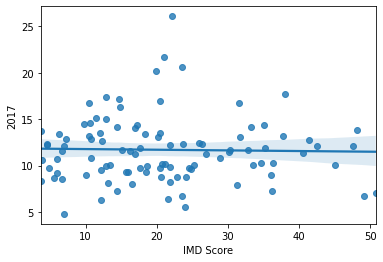

In [150]:
sns.regplot(data=gdf.sample(500), x=gdf["IMD Score"].sample(100), y=gdf["2017"].sample(100))

<AxesSubplot:xlabel='IMD Score', ylabel='2017'>

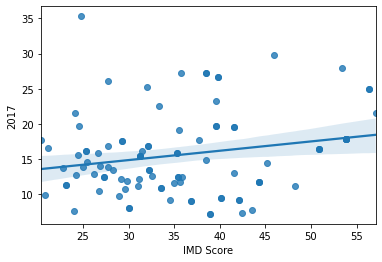

In [144]:
sns.regplot(data=gdf_newham.sample(100), x="IMD Score", y="2017")

<AxesSubplot:xlabel='HOUSE_DETACHED', ylabel='2017'>

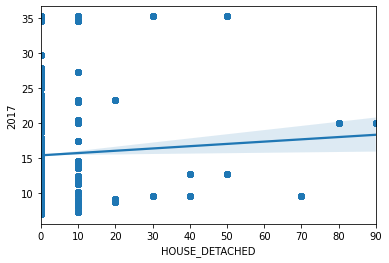

In [94]:
sns.regplot(data=gdf_newham.sample(200), x=gdf_newham["HOUSE_DETACHED"], y=gdf_newham["2017"])

<AxesSubplot:xlabel='pre1900-1939(old)', ylabel='2017'>

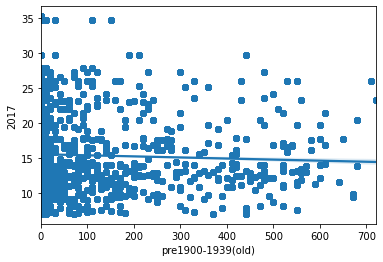

In [96]:
sns.regplot(data=gdf_newham.sample(200), x=gdf_newham["pre1900-1939(old)"], y=gdf_newham["2017"])

In [14]:
W_queen= Queen.from_dataframe(gdf)
W_queen.transform = 'r' 

KeyboardInterrupt: 

In [71]:
gdf.columns

Index(['lsoa11cd', 'AREA_NAME', 'BUNGALOW', 'FLAT_MAIS', 'HOUSE_TERRACED',
       'HOUSE_SEMI', 'HOUSE_DETACHED', 'ANNEXE', 'ALL_PROPERTIES',
       'BUNGALOW&ANNEXE', 'HOUSE_TERRACED&HOUSE_SEMI', 'geometry'],
      dtype='object')

0.041280849609360896
0.001


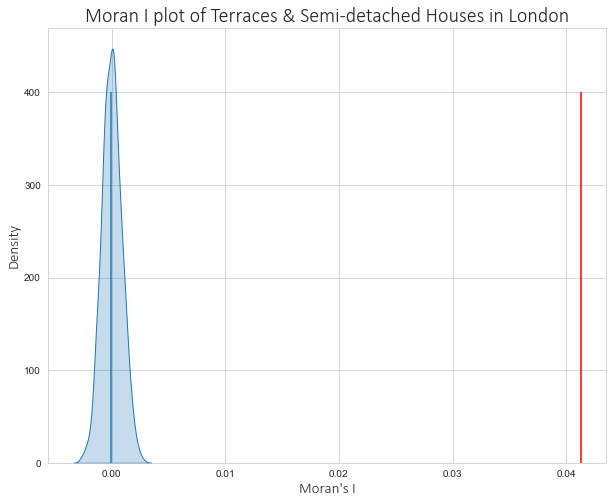

In [77]:
from pysal.explore import esda 
fig = plt.figure(figsize=(10, 8))
sns.set_style("whitegrid")
mi = esda.moran.Moran(gdf['HOUSE_TERRACED&HOUSE_SEMI'], W_queen) # call moran function
print(mi.I) # Moran's I value
print(mi.p_sim) #inference on Moran's I

ax = sns.kdeplot(mi.sim, shade=True)
ax.set_title(label = "Moran I plot of Terraces & Semi-detached Houses in London", fontdict={'fontsize': '20', 'fontweight' : '3', 'family': 'Calibri'} )
plt.vlines(mi.I, 0, 400, color='r')
plt.vlines(mi.EI, 0, 400)
plt.xlabel("Moran's I", fontdict={'fontsize': '15', 'fontweight' : '3', 'family': 'Calibri'})
plt.ylabel("Density", fontdict={'fontsize': '15', 'fontweight' : '3', 'family': 'Calibri'})
plt.savefig("Moran I plot of Terraces & Semi-detached Houses(0.0413).png", format="png")
plt.show()

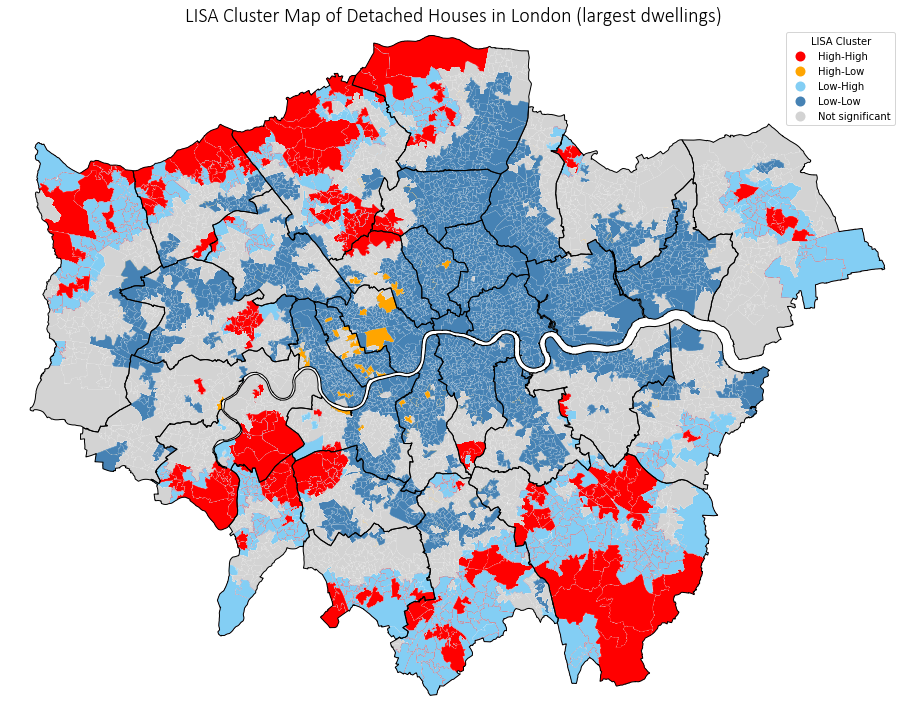

In [66]:
lisa = ps.explore.esda.Moran_Local(gdf['HOUSE_DETACHED'].values, W_queen, permutations=999)
lisa.Is

sig = 1 * (lisa.p_sim < 0.05)
hotspot = 1 * (sig * lisa.q==1)
coldspot = 3 * (sig * lisa.q==3)
doughnut = 2 * (sig * lisa.q==2)
diamond = 4 * (sig * lisa.q==4)

spots = hotspot + coldspot + doughnut + diamond
spots

spot_labels = [ 'Not significant', 'High-High', 'Low-High', 'Low-Low', 'High-Low']
labels = [spot_labels[i] for i in spots]


from matplotlib import colors

def plt_ldn(b=boroughs):
    fig, ax = plt.subplots(1, figsize=(16, 14))
    b.plot(ax=ax, edgecolor='black', facecolor='None', zorder=3)
    ax.set_xlim([502000,563000])
    ax.set_ylim([155000,201500])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    return fig, ax

hmap = colors.ListedColormap([ 'red', 'orange', '#83cef4', 'steelblue', 'lightgrey'])
fig, ax = plt_ldn()
gdf.assign(cl=labels).plot(column='cl', categorical=True, \
        k=5, cmap=hmap, linewidth=0.1, ax=ax, \
        edgecolor='white', legend=True)
ax.set_axis_off()
plt.title("LISA Cluster Map of Detached Houses in London (largest dwellings)", fontdict={'fontsize': '20', 'fontweight' : '3', 'family': 'Calibri'})
leg = ax.get_legend()
leg.set_title("LISA Cluster")

plt.savefig("LISA Cluster Map of Detached Houses")

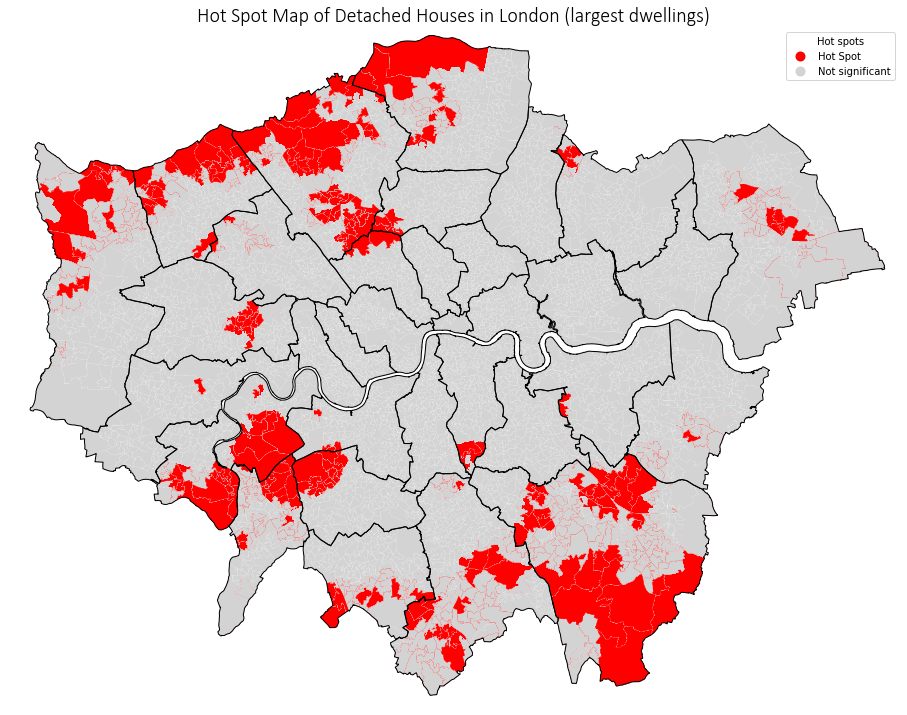

In [67]:
sig = lisa.p_sim < 0.05
hotspot = sig * lisa.q==1
coldspot = sig * lisa.q==3

spots = ['Not significant', 'Hot Spot']
labels = [spots[i] for i in hotspot*1]

from matplotlib import colors
hmap = colors.ListedColormap(['red', 'lightgrey'])
f, ax = plt_ldn()
gdf.assign(cl=labels).plot(column='cl', categorical=True, \
        k=2, cmap=hmap, linewidth=0.1, ax=ax, \
        edgecolor='white', legend=True)
ax.set_axis_off()
plt.title("Hot Spot Map of Detached Houses in London (largest dwellings)", fontdict={'fontsize': '20', 'fontweight' : '3', 'family': 'Calibri'})
leg = ax.get_legend()
leg.set_title("Hot spots")
plt.savefig("Hot Spot Map of Detached Houses in London")
plt.show()

In [18]:
#Creating shapefile
crs = {'init':'epsg:4326'}
gdf = gpd.GeoDataFrame(gdf, crs = crs, geometry = 'geometry')
# convert the .csv file into .shp file 
gdf.to_file(driver='ESRI Shapefile', filename='data/group_project.shp', encoding='latin1')
# reprojection 
gdf.to_crs(epsg=27700)

lsoa11cd          AREA_NAME_x  BP_PRE_1900  BP_1900_1918  \
0       E01000001  City of London 001A           60             0   
1       E01000001  City of London 001A           60             0   
2       E01000001  City of London 001A           60             0   
3       E01000001  City of London 001A           60             0   
4       E01000001  City of London 001A           60             0   
...           ...                  ...          ...           ...   
375997  E01004765     Westminster 013D           30             0   
375998  E01004765     Westminster 013D           30             0   
375999  E01004765     Westminster 013D           30             0   
376000  E01004765     Westminster 013D           30             0   
376001  E01004765     Westminster 013D           30             0   

        BP_1919_1929  BP_1930_1939  BP_1945_1954  BP_1955_1964  BP_1965_1972  \
0                  0             0             0            50           840   
1                  0             0             0            50           840   
2                  0             0             0            50           840   
3                  0             0             0            50           840   
4                  0             0             0            50           840   
...              ...           ...           ...           ...           ...   
375997            30             0             0            10             0   
375998            30             0             0            10             0   
375999            30             0             0            10             0   
376000            30             0             0            10             0   
376001            30             0             0            10             0   

        BP_1973_1982  ...  2011       LSOA 2011 Name       LA Name_y  2012  \
0                 10  ...   4.0  City of London 001A  City of London   5.8   
1                 10  ...   4.0  City of London 001A  City of London   5.8   
2                 10  ...   4.0  City of London 001A  City of London   5.8   
3                 10  ...   4.0  City of London 001A  City of London   5.8   
4                 10  ...   4.0  City of London 001A  City of London   5.8   
...              ...  ...   ...                  ...             ...   ...   
375997             0  ...   7.2     Westminster 013D     Westminster  12.2   
375998             0  ...   7.2     Westminster 013D     Westminster  12.2   
375999             0  ...   7.2     Westminster 013D     Westminster  12.2   
376000             0  ...   7.2     Westminster 013D     Westminster  12.2   
376001             0  ...   7.2     Westminster 013D     Westminster  12.2   

        2013  2014  2015  2016  2017  \
0        3.4   9.1   4.1   4.3   4.2   
1        3.4   9.1   4.1   4.3   4.2   
2        3.4   9.1   4.1   4.3   4.2   
3        3.4   9.1   4.1   4.3   4.2   
4        3.4   9.1   4.1   4.3   4.2   
...      ...   ...   ...   ...   ...   
375997   8.0   9.6   9.1   8.8   3.8   
375998   8.0   9.6   9.1   8.8   3.8   
375999   8.0   9.6   9.1   8.8   3.8   
376000   8.0   9.6   9.1   8.8   3.8   
376001   8.0   9.6   9.1   8.8   3.8   

                                                 geometry  
0       POLYGON ((532095.563 181577.351, 532095.125 18...  
1       POLYGON ((532095.563 181577.351, 532095.125 18...  
2       POLYGON ((532095.563 181577.351, 532095.125 18...  
3       POLYGON ((532095.563 181577.351, 532095.125 18...  
4       POLYGON ((532095.563 181577.351, 532095.125 18...  
...                                                   ...  
375997  POLYGON ((528673.184 181605.773, 528668.346 18...  
375998  POLYGON ((528673.184 181605.773, 528668.346 18...  
375999  POLYGON ((528673.184 181605.773, 528668.346 18...  
376000  POLYGON ((528673.184 181605.773, 528668.346 18...  
376001  POLYGON ((528673.184 181605.773, 528668.346 18...  

[376002 rows x 42 columns]

In [ ]:
#constructing Queen weights
W_queen= Queen.from_dataframe(gdf)
W_queen.transform = 'r' # row-standardize the contiguity weights
#W_queen = Queen.from_shapefile('data/group_project.shp')

In [ ]:
from pysal.explore import esda 
fig = plt.figure(figsize=(10, 8))
sns.set_style("whitegrid")
mi = esda.moran.Moran(gdf['pre1900-1939(old)'], W_queen) # call moran function
print(mi.I) # Moran's I value
print(mi.p_sim) #inference on Moran's I

ax = sns.kdeplot(mi.sim, shade=True)
ax.set_title(label = "Moran I plot of oldest houses in London: pre1900 - 1939", fontdict={'fontsize': '20', 'fontweight' : '3', 'family': 'Calibri'} )
plt.vlines(mi.I, 0, 400, color='r')
plt.vlines(mi.EI, 0, 400)
plt.xlabel("Moran's I",  fontdict={'fontsize': '15', 'fontweight' : '3', 'family': 'Calibri'})
plt.ylabel("Density",  fontdict={'fontsize': '15', 'fontweight' : '3', 'family': 'Calibri'})
plt.savefig("Moran I plot of oldest houses in London: pre1900 - 1939.png", format="png")
plt.show()

In [ ]:
from splot.esda import moran_scatterplot
from esda.moran import Moran_Local
y = gdf['pre1900-1939(old)'].values
moran_loc = Moran_Local(y, W_queen)
fig, ax = moran_scatterplot(moran_loc)
ax.set_xlabel('Oldest Houses')
ax.set_ylabel('Spatial Lag of oldest houses')
plt.show()

moran_scatterplot(moran_loc, p=0.05 )
axs.set_xlabel('Oldest Houses')
axs.set_ylabel('Spatial Lag of oldest houses')
plt.show()

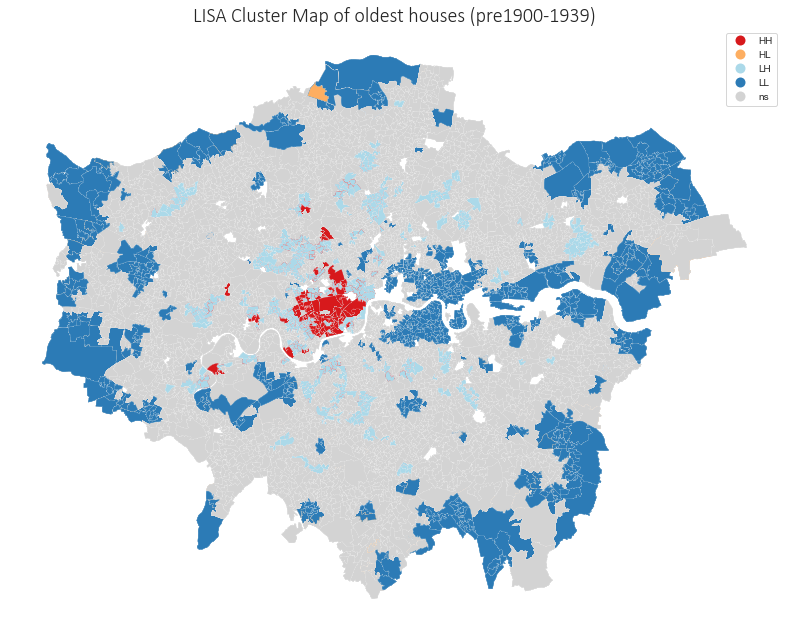

In [150]:
#local Moran I statistics and hotspot/coldspot maps
lisa = ps.explore.esda.Moran_Local(gdf['pre1900-1939(old)'].values, W_queen, permutations=999)
import splot
from splot.esda import lisa_cluster
lisa_cluster(lisa, gdf, figsize=(15, 11))
plt.title("LISA Cluster Map of oldest houses (pre1900-1939)", fontdict={'fontsize': '20', 'fontweight' : '3', 'family': 'Calibri'})
plt.savefig("LISA Cluster Map of oldest houses (pre1900-1939)")

In [29]:
sig = lisa.p_sim < 0.05
hotspot = sig * lisa.q==1
coldspot = sig * lisa.q==3

print(len(gdf[hotspot]))
print(len(gdf[coldspot]))

1875
5831


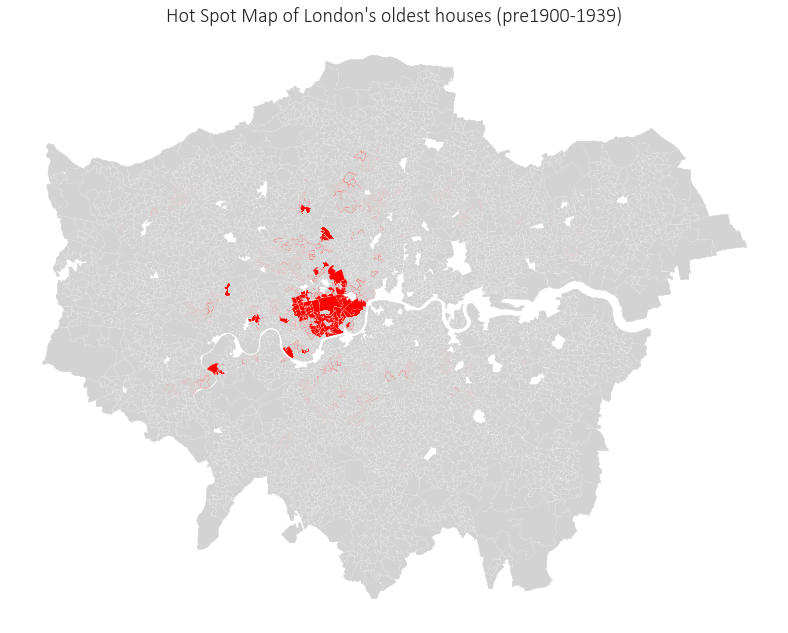

In [37]:
spots = ['Not significant', 'Hot Spot']
labels = [spots[i] for i in hotspot*1]

from matplotlib import colors
hmap = colors.ListedColormap(['red', 'lightgrey'])
f, ax = plt.subplots(1, figsize=(14, 11))
gdf.assign(cl=labels).plot(column='cl', categorical=True, \
        k=2, cmap=hmap, linewidth=0.1, ax=ax, \
        edgecolor='white', legend=True)
ax.set_axis_off()
plt.title("Hot Spot Map of London's oldest houses (pre1900-1939)", fontdict={'fontsize': '20', 'fontweight' : '3', 'family': 'Calibri'})
plt.savefig("Hot Spot Map of oldest houses (pre1900-1939)")
plt.show()

0.06972910940186339
0.001


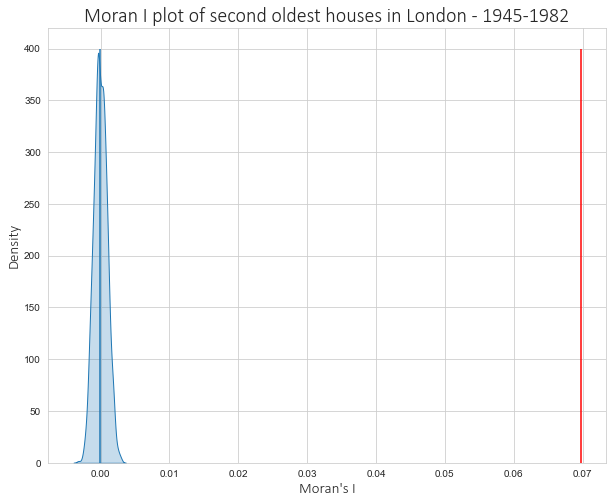

In [38]:
from pysal.explore import esda 
fig = plt.figure(figsize=(10, 8))
sns.set_style("whitegrid")
mi = esda.moran.Moran(gdf['1945-1982(medium)'], W_queen) # call moran function
print(mi.I) # Moran's I value
print(mi.p_sim) #inference on Moran's I

ax = sns.kdeplot(mi.sim, shade=True)
ax.set_title(label = "Moran I plot of second oldest houses in London - 1945-1982", fontdict={'fontsize': '20', 'fontweight' : '3', 'family': 'Calibri'} )
plt.vlines(mi.I, 0, 400, color='r')
plt.vlines(mi.EI, 0, 400)
plt.xlabel("Moran's I", fontdict={'fontsize': '15', 'fontweight' : '3', 'family': 'Calibri'})
plt.ylabel("Density", fontdict={'fontsize': '15', 'fontweight' : '3', 'family': 'Calibri'})
plt.savefig("Moran I plot of medium-age houses in London: 1945-1982.png", format="png")
plt.show()

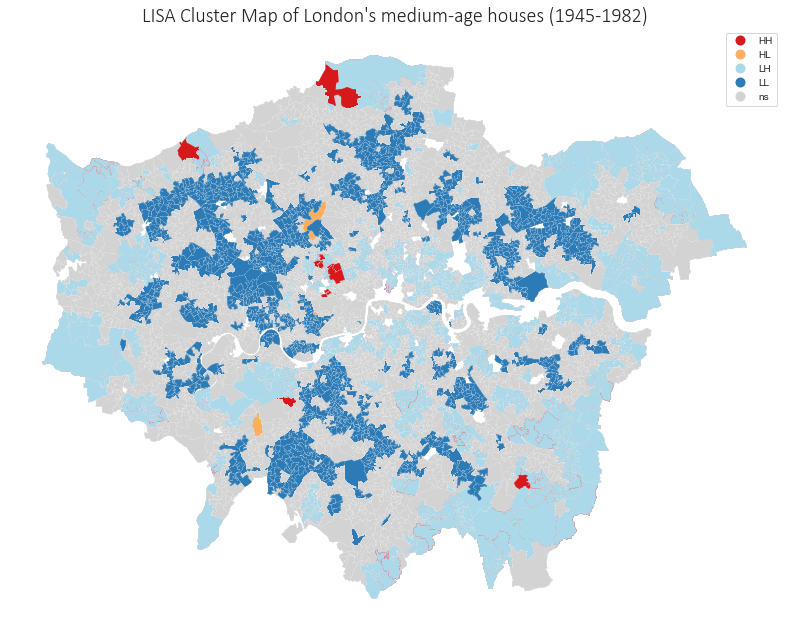

In [39]:
#local Moran I statistics and hotspot/coldspot maps
lisa = ps.explore.esda.Moran_Local(gdf['1945-1982(medium)'].values, W_queen, permutations=999)
import splot
from splot.esda import lisa_cluster
lisa_cluster(lisa, gdf, figsize=(15, 11))
plt.title("LISA Cluster Map of London's medium-age houses (1945-1982)", fontdict={'fontsize': '20', 'fontweight' : '3', 'family': 'Calibri'})
plt.savefig("LISA Cluster Map of medium-age houses (1945-1982)")

In [40]:
sig = lisa.p_sim < 0.05
hotspot = sig * lisa.q==1
coldspot = sig * lisa.q==3

print(len(gdf[hotspot]))
print(len(gdf[coldspot]))

2717
10554


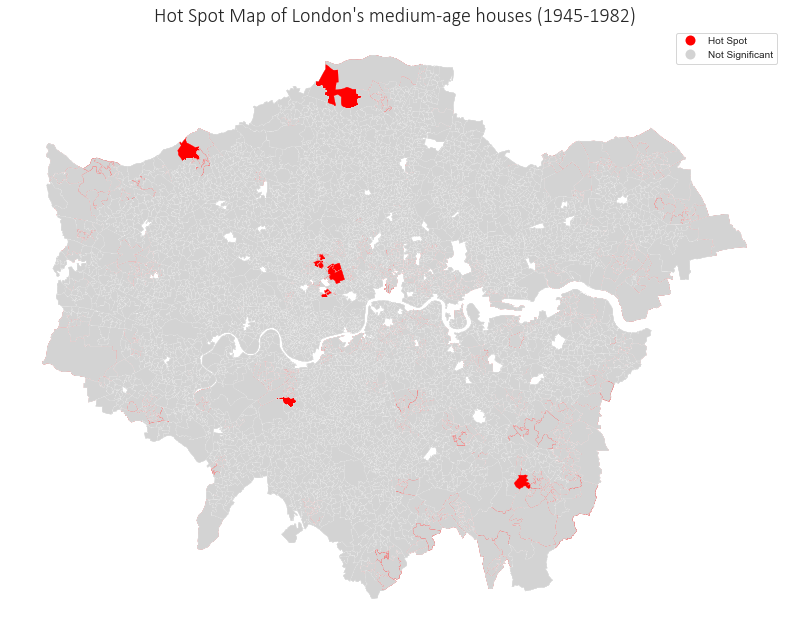

In [41]:
spots = ['Not Significant', 'Hot Spot']
labels = [spots[i] for i in hotspot*1]

from matplotlib import colors
hmap = colors.ListedColormap(['red', 'lightgrey'])
f, ax = plt.subplots(1, figsize=(14, 11))
gdf.assign(cl=labels).plot(column='cl', categorical=True, \
        k=2, cmap=hmap, linewidth=0.1, ax=ax, \
        edgecolor='white', legend=True)
ax.set_axis_off()
plt.title("Hot Spot Map of London's medium-age houses (1945-1982)", fontdict={'fontsize': '20', 'fontweight' : '3', 'family': 'Calibri'})
plt.savefig("Hot Spot Map of medium-age houses (1945-1982)")
plt.show()

0.07215942216956675
0.001


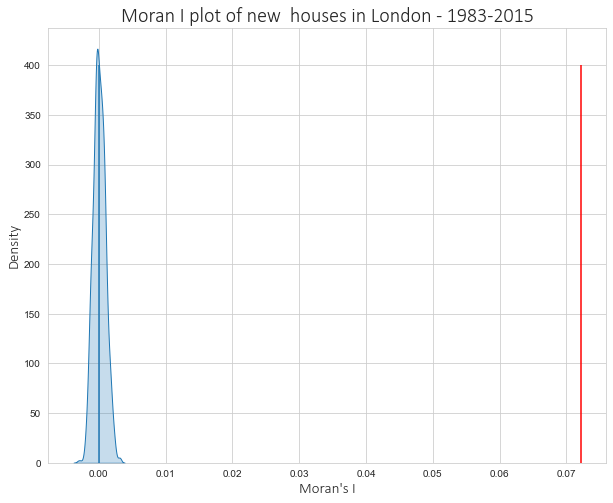

In [44]:
from pysal.explore import esda 
mi = esda.moran.Moran(gdf['1983-2015(new)'], W_queen) # call moran function
print(mi.I) # Moran's I value
print(mi.p_sim) #inference on Moran's I
fig = plt.figure(figsize=(10, 8))
ax = sns.kdeplot(mi.sim, shade=True)
ax.set_title(label = "Moran I plot of new  houses in London - 1983-2015", fontdict={'fontsize': '20', 'fontweight' : '3', 'family': 'Calibri'} )
plt.vlines(mi.I, 0, 400, color='r')
plt.vlines(mi.EI, 0, 400)
plt.xlabel("Moran's I", fontdict={'fontsize': '15', 'fontweight' : '3', 'family': 'Calibri'})
plt.ylabel("Density", fontdict={'fontsize': '15', 'fontweight' : '3', 'family': 'Calibri'})
plt.savefig("Moran I plot of new houses in London: 1983-2015.png", format="png")
plt.show()

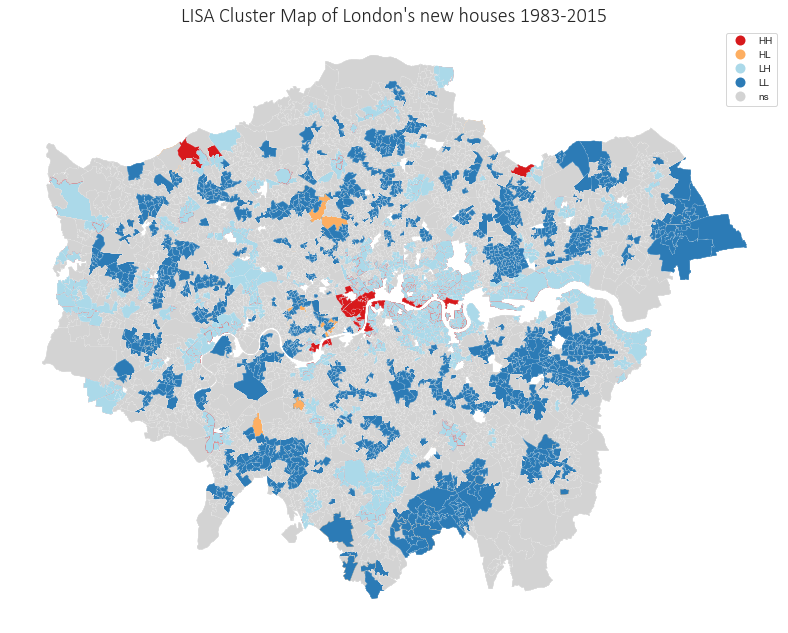

In [46]:
#local Moran I statistics and hotspot/coldspot maps
lisa = ps.explore.esda.Moran_Local(gdf['1983-2015(new)'].values, W_queen, permutations=999)
import splot
from splot.esda import lisa_cluster
lisa_cluster(lisa, gdf, figsize=(15, 11))
plt.title("LISA Cluster Map of London's new houses 1983-2015", fontdict={'fontsize': '20', 'fontweight' : '3', 'family': 'Calibri'})
plt.savefig("LISA Cluster Map of new houses  1983-2015")

In [48]:
sig = lisa.p_sim < 0.05
hotspot = sig * lisa.q==1
coldspot = sig * lisa.q==3

print(len(gdf[hotspot]))
print(len(gdf[coldspot]))

1203
11450


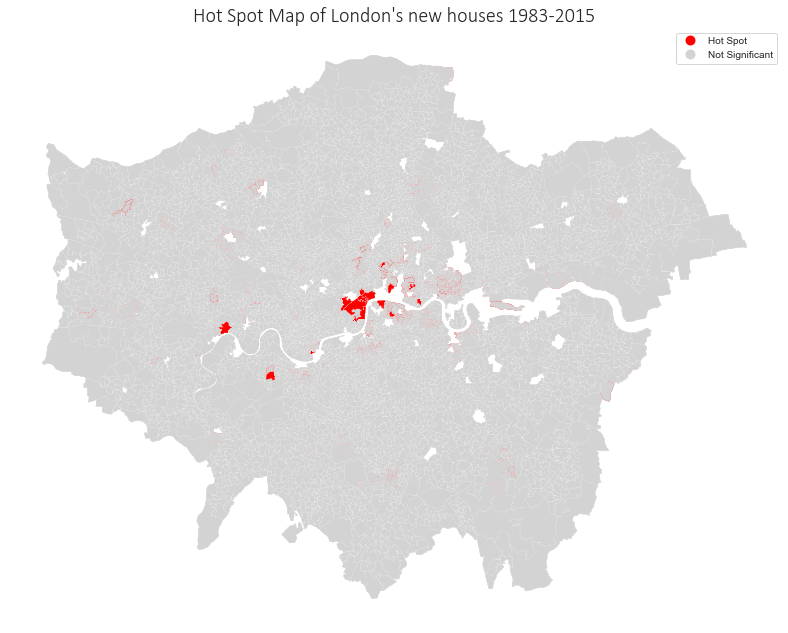

In [49]:
spots = ['Not Significant', 'Hot Spot']
labels = [spots[i] for i in hotspot*1]

from matplotlib import colors
hmap = colors.ListedColormap(['red', 'lightgrey'])
f, ax = plt.subplots(1, figsize=(14, 11))
gdf.assign(cl=labels).plot(column='cl', categorical=True, \
        k=2, cmap=hmap, linewidth=0.1, ax=ax, \
        edgecolor='white', legend=True)
ax.set_axis_off()
plt.title("Hot Spot Map of London's new houses 1983-2015", fontdict={'fontsize': '20', 'fontweight' : '3', 'family': 'Calibri'})
plt.savefig("Hot Spot Map of new houses 1983-2015")
plt.show()

In [ ]:
print(fuel_2017['2017'].max())
print(fuel_2017['2017'].min())
print(fuel_2017['2017'].mode())
fig = plt.figure(figsize=(10, 8))
fig, ax = plt_ldn()
gdf.plot(column='2017', scheme='quantiles', k=4, legend=True, ax=ax, edgecolor='grey', linewidth=0.2, cmap = 'coolwarm') 
ax.axis('off') 
ax.set_title('Fuel powerty in 2017', fontdict={'fontsize': '20', 'fontweight' : '3', 'family': 'Calibri'}), #provide a title
ax.annotate('Source: London Data Store (2011)',xy=(0.1, 0.1), xycoords='figure fraction', horizontalalignment='left', verticalalignment='top', fontsize=12, color='#555555') #add source info on the image itself
leg = ax.get_legend()
plt.savefig("Fuel powerty in 2017 (quantiles map)")
plt.show()

38.7
2.1
0    11.7
dtype: float64


0.45531138752806094
0.001


Text(0, 0.5, 'Density')

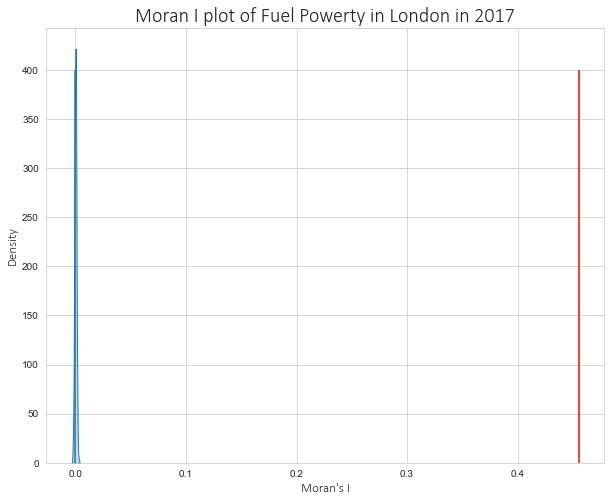

In [61]:
from pysal.explore import esda 
fig = plt.figure(figsize=(10, 8))
mi = esda.moran.Moran(gdf['2017'], W_queen) # call moran function
print(mi.I) # Moran's I value
print(mi.p_sim) #inference on Moran's I

ax = sns.kdeplot(mi.sim, shade=True)
ax.set_title(label = "Moran I plot of Fuel Powerty in London in 2017", fontdict={'fontsize': '20', 'fontweight' : '3', 'family': 'Calibri'} )
plt.vlines(mi.I, 0, 400, color='r')
plt.vlines(mi.EI, 0, 400)
plt.xlabel("Moran's I", fontdict={'fontsize': '13', 'fontweight' : '3', 'family': 'Calibri'})
plt.ylabel("Density", fontdict={'fontsize': '13', 'fontweight' : '3', 'family': 'Calibri'})

In [37]:
gdf['points'] = gdf['geometry'].centroid


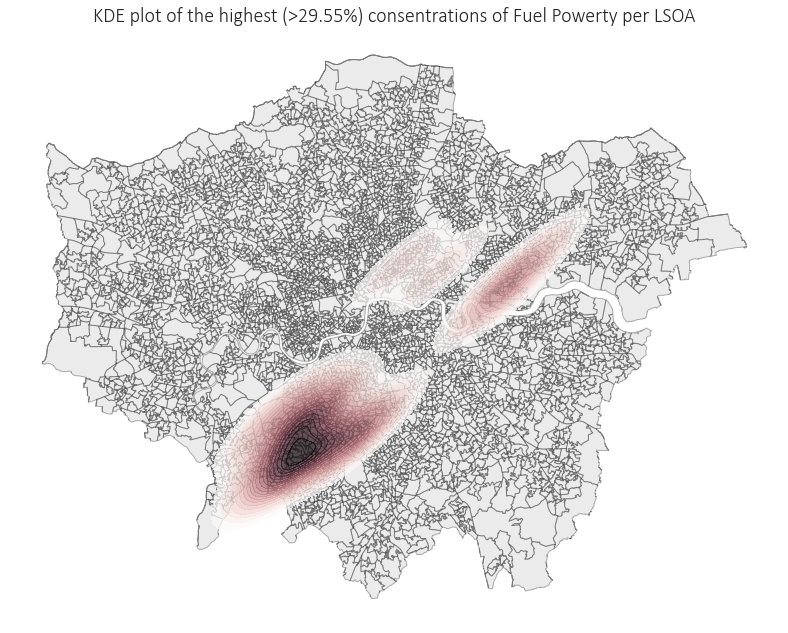

In [41]:
df_p = gdf[gdf['2017'] >= 29.55] #the highest section of fuel powerty
s =  df_p['points']
x = s.apply(lambda p: p.x)
y = s.apply(lambda p: p.y)

fig, ax = plt.subplots(1,1,figsize=(15,11))
lsoa.plot(ax=ax, color = 'silver', edgecolor = 'black', alpha = 0.3)
cmap = sns.cubehelix_palette(as_cmap = True, dark =1, light =0, reverse = True, start=0.73, rot=.1)
ax.axis('off')
sns.kdeplot(x, y, cmap = cmap, n_levels =20, shade =True, alpha = 0.7,  shade_lowest = False)
ax.set_title(label = "KDE plot of the highest (>29.55%) consentrations of Fuel Powerty per LSOA", fontdict={'fontsize': '20', 'fontweight' : '3',  'family': 'Calibri'} )
fig.savefig('The highest fuel powerty hot spots.png', dpi=300)

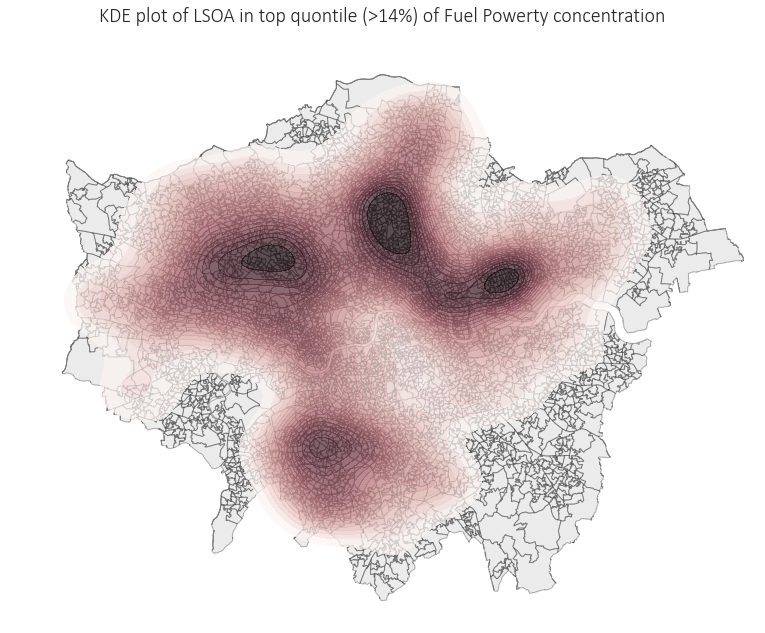

In [42]:
df_p = gdf[gdf['2017'] >= 14.0] #top quantile of fuel powerty
s =  df_p['points']
x = s.apply(lambda p: p.x)
y = s.apply(lambda p: p.y)

fig, ax = plt.subplots(1,1,figsize=(15,11))
lsoa.plot(ax=ax, color = 'silver', edgecolor = 'black', alpha = 0.3)
cmap = sns.cubehelix_palette(as_cmap = True, dark =1, light =0, reverse = True, start=0.73, rot=.1)
ax.axis('off')
sns.kdeplot(x, y, cmap = cmap, n_levels =20, shade =True, alpha = 0.7,  shade_lowest = False)
ax.set_title(label = "KDE plot of LSOA in top quontile (>14%) of Fuel Powerty concentration", fontdict={'fontsize': '20', 'fontweight' : '3',  'family': 'Calibri'} )
fig.savefig('Top qountile.png', dpi=300)

In [4]:
#local Moran I statistics and hotspot/coldspot maps
lisa = ps.explore.esda.Moran_Local(gdf['2017'].values, W_queen, permutations=999)
import splot
from splot.esda import lisa_cluster
lisa_cluster(lisa, gdf, figsize=(15, 11))
plt.title("LISA Cluster Map of Fuel Powerty in London", fontdict={'fontsize': '20', 'fontweight' : '3', 'family': 'Calibri'})
plt.savefig("LISA Cluster Map of Fuel Powerty")

AttributeError: module 'pysal' has no attribute 'explore'

In [45]:
sig = lisa.p_sim < 0.05
hotspot = sig * lisa.q==1
coldspot = sig * lisa.q==3

print(len(gdf[hotspot]))
print(len(gdf[coldspot]))

9360
14769


In [1]:
spots = ['Not Significant', 'Hot Spot']
labels = [spots[i] for i in hotspot*1]

from matplotlib import colors
hmap = colors.ListedColormap(['red', 'white'])
f, ax = plt.subplots(1, figsize=(14, 11))
gdf.assign(cl=labels).plot(column='cl', categorical=True, \
        k=2, cmap=hmap, linewidth=0.1, ax=ax, \
        edgecolor='white', legend=True)
ax.set_axis_off()
plt.title("Hot Spot Map of Fuel Powerty", fontdict={'fontsize': '20', 'fontweight' : '3', 'family': 'Calibri'})
plt.savefig("Hot Spot Map of Fuel Powerty")
plt.show()

NameError: name 'hotspot' is not defined

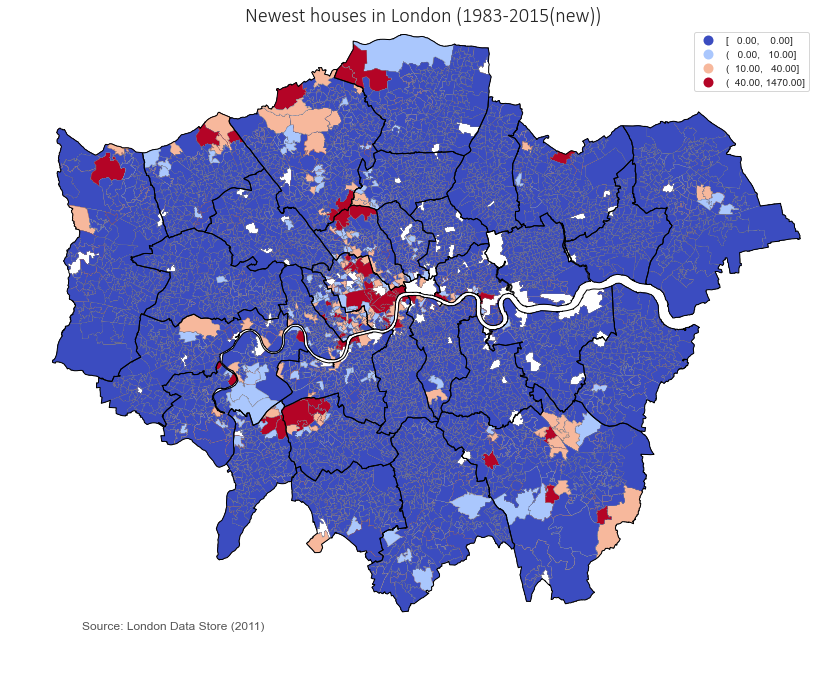

In [197]:
fig, ax = plt_ldn()
gdf.plot(column='1983-2015(new)', scheme='quantiles', k=6, legend=True, ax=ax, edgecolor='grey', linewidth=0.2, cmap = 'coolwarm') 
ax.axis('off') 
ax.set_title('Newest houses in London (1983-2015(new))', fontdict={'fontsize': '20', 'fontweight' : '3', 'family': 'Calibri'}), #provide a title
ax.annotate('Source: London Data Store (2011)',xy=(0.1, 0.1), xycoords='figure fraction', horizontalalignment='left', verticalalignment='top', fontsize=12, color='#555555') #add source info on the image itself
leg = ax.get_legend()
fig.savefig('Quantile map of newest houses in London.png', dpi=300)

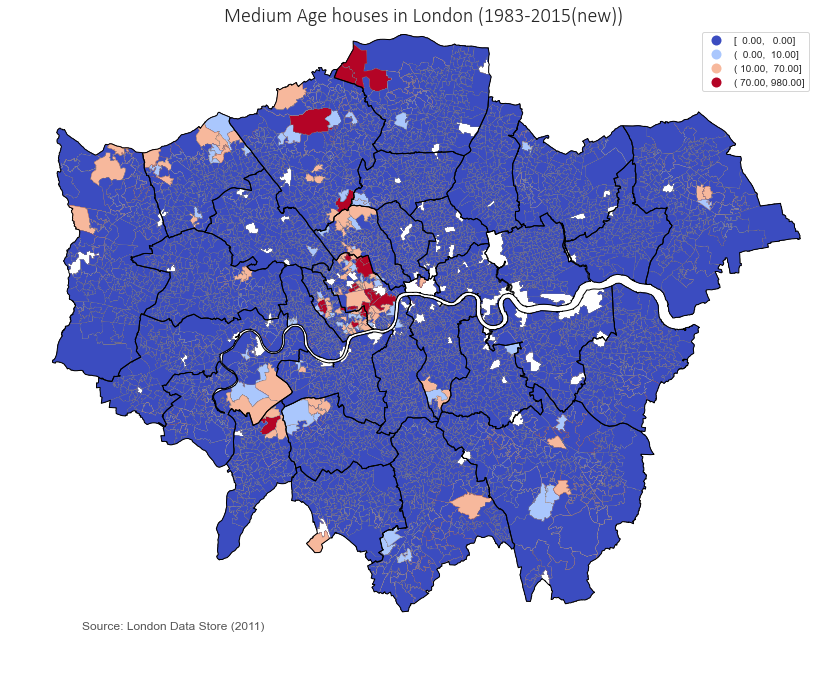

In [198]:

fig, ax = plt_ldn()
gdf.plot(column='1945-1982(medium)', scheme='quantiles', k=6, legend=True, ax=ax, edgecolor='grey', linewidth=0.2, cmap = 'coolwarm') 
ax.axis('off') 
ax.set_title('Medium Age houses in London (1983-2015(new))', fontdict={'fontsize': '20', 'fontweight' : '3', 'family': 'Calibri'}), #provide a title
ax.annotate('Source: London Data Store (2011)',xy=(0.1, 0.1), xycoords='figure fraction', horizontalalignment='left', verticalalignment='top', fontsize=12, color='#555555') #add source info on the image itself
leg = ax.get_legend()
fig.savefig('Quantile map of medium-aged houses in London.png', dpi=300)

In [ ]:
fig, ax = plt_ldn()
gdf.plot(column='IMD Score', scheme='quantiles', k=4, legend=True, ax=ax, edgecolor='grey', linewidth=0.2, cmap = 'coolwarm') 
ax.axis('off') 
ax.set_title('Oldest houses in London (1983-2015(new))', fontdict={'fontsize': '20', 'fontweight' : '3', 'family': 'Calibri'}), #provide a title
ax.annotate('Source: London Data Store (2011)',xy=(0.1, 0.1), xycoords='figure fraction', horizontalalignment='left', verticalalignment='top', fontsize=12, color='#555555') #add source info on the image itself
leg = ax.get_legend()
fig.savefig('Quantile map of oldest houses in London.png', dpi=300)

In [55]:
gdf.columns

Index(['lsoa11cd', 'LSOA 2001 Name', 'LA Name_x', '2009', '2010', '2011',
       'AREA_NAME_x', 'BP_PRE_1900', 'BP_1900_1918', 'BP_1919_1929',
       'BP_1930_1939', 'BP_1945_1954', 'BP_1955_1964', 'BP_1965_1972',
       'BP_1973_1982', 'BP_1983_1992', 'BP_1993_1999', 'BP_2000_2009',
       'BP_2010_2015', 'BP_UNKNOWN', 'ALL_PROPERTIES_x', 'pre1900-1939(old)',
       '1945-1982(medium)', '1983-2015(new)', 'LSOA 2011 Name', 'LA Name_y',
       '2012', '2013', '2014', '2015', '2016', '2017', 'geometry',
       'AREA_NAME_y', 'BUNGALOW', 'FLAT_MAIS', 'HOUSE_TERRACED', 'HOUSE_SEMI',
       'HOUSE_DETACHED', 'ANNEXE', 'ALL_PROPERTIES_y', 'IMD Score'],
      dtype='object')

In [56]:
from pysal.explore import esda 
fig = plt.figure(figsize=(10, 8))
mi = esda.moran.Moran(gdf['IMD Score'], W_queen) # call moran function
print(mi.I) # Moran's I value
print(mi.p_sim) #inference on Moran's I

ax = sns.kdeplot(mi.sim, shade=True)
ax.set_title(label = "Moran I plot of IMD Score in London in 2015", fontdict={'fontsize': '20', 'fontweight' : '3', 'family': 'Calibri'} )
plt.vlines(mi.I, 0, 400, color='r')
plt.vlines(mi.EI, 0, 400)
plt.xlabel("Moran's I", fontdict={'fontsize': '13', 'fontweight' : '3', 'family': 'Calibri'})
plt.ylabel("Density", fontdict={'fontsize': '13', 'fontweight' : '3', 'family': 'Calibri'})

NameError: name 'W_queen' is not defined

<Figure size 720x576 with 0 Axes>

In [17]:
gdf['pre1900-1939(old)PROP'] = (gdf['BP_PRE_1900'] + gdf['BP_1900_1918'] + gdf['BP_1919_1929'] + gdf['BP_1930_1939'])/(gdf['BP_PRE_1900'] + gdf['BP_1900_1918'] + gdf['BP_1919_1929'] + gdf['BP_1930_1939']+ gdf['BP_1945_1954'] + gdf['BP_1955_1964'] +  gdf['BP_1965_1972'] + gdf['BP_1973_1982']+gdf['BP_1983_1992'] + gdf['BP_1993_1999'] +gdf['BP_2000_2009'] + gdf['BP_2010_2015']) 
gdf['1945-1982(medium)PROP'] =  (gdf['BP_1945_1954'] + gdf['BP_1955_1964'] +  gdf['BP_1965_1972'] + gdf['BP_1973_1982'])/(gdf['BP_PRE_1900'] + gdf['BP_1900_1918'] + gdf['BP_1919_1929'] + gdf['BP_1930_1939']+ gdf['BP_1945_1954'] + gdf['BP_1955_1964'] +  gdf['BP_1965_1972'] + gdf['BP_1973_1982']+gdf['BP_1983_1992'] + gdf['BP_1993_1999'] +gdf['BP_2000_2009'] + gdf['BP_2010_2015'])
gdf['1983-2015(new)PROP'] = (gdf['BP_1983_1992'] + gdf['BP_1993_1999'] +gdf['BP_2000_2009'] + gdf['BP_2010_2015'])/(gdf['BP_PRE_1900'] + gdf['BP_1900_1918'] + gdf['BP_1919_1929'] + gdf['BP_1930_1939']+ gdf['BP_1945_1954'] + gdf['BP_1955_1964'] +  gdf['BP_1965_1972'] + gdf['BP_1973_1982']+gdf['BP_1983_1992'] + gdf['BP_1993_1999'] +gdf['BP_2000_2009'] + gdf['BP_2010_2015'])
gdf['pre1900-1939(old)PROP'].fillna(0, inplace=True)
gdf['1945-1982(medium)PROP'].fillna(0, inplace=True)
gdf['1983-2015(new)PROP'].fillna(0, inplace=True)

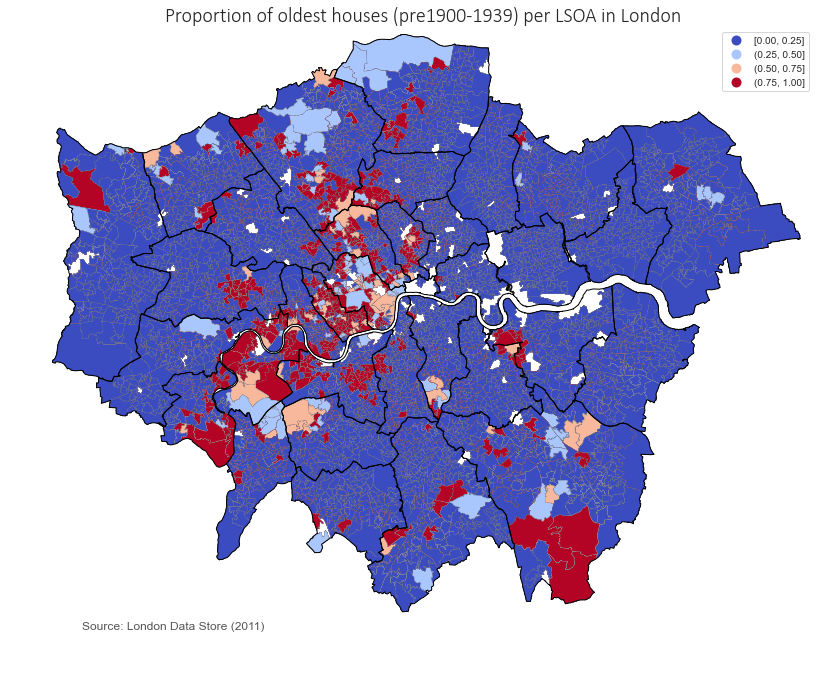

In [201]:
fig, ax = plt_ldn()
gdf.plot(column='pre1900-1939(old)PROP', scheme='EqualInterval', k=4, legend=True, ax=ax, edgecolor='grey', linewidth=0.2, cmap = 'coolwarm') 
ax.axis('off') 
ax.set_title('Proportion of oldest houses (pre1900-1939) per LSOA in London', fontdict={'fontsize': '20', 'fontweight' : '3', 'family': 'Calibri'}), #provide a title
ax.annotate('Source: London Data Store (2011)',xy=(0.1, 0.1), xycoords='figure fraction', horizontalalignment='left', verticalalignment='top', fontsize=12, color='#555555') #add source info on the image itself
leg = ax.get_legend()
fig.savefig('Proportion map of oldest houses in London.png', dpi=300)

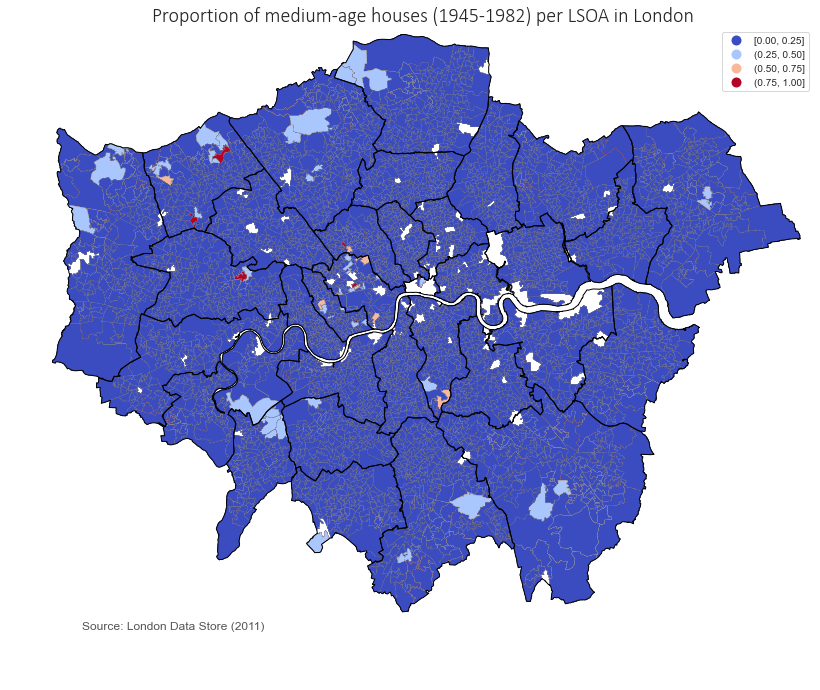

In [202]:
fig, ax = plt_ldn()
gdf.plot(column='1945-1982(medium)PROP', scheme='EqualInterval', k=4, legend=True, ax=ax, edgecolor='grey', linewidth=0.2, cmap = 'coolwarm') 
ax.axis('off') 
ax.set_title('Proportion of medium-age houses (1945-1982) per LSOA in London', fontdict={'fontsize': '20', 'fontweight' : '3', 'family': 'Calibri'}), #provide a title
ax.annotate('Source: London Data Store (2011)',xy=(0.1, 0.1), xycoords='figure fraction', horizontalalignment='left', verticalalignment='top', fontsize=12, color='#555555') #add source info on the image itself
leg = ax.get_legend()
fig.savefig('Proportion map of medium-age houses in London.png', dpi=300)

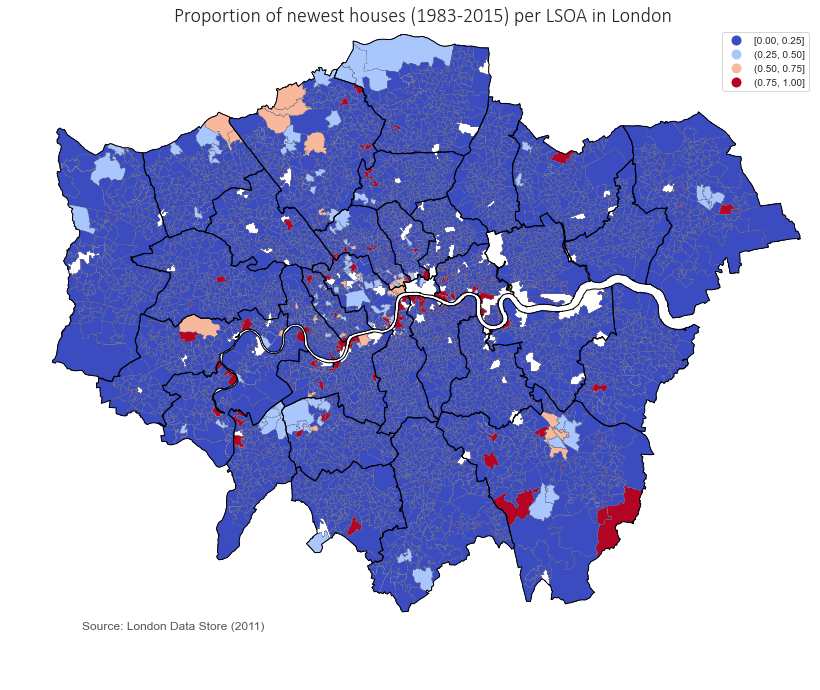

In [203]:
fig, ax = plt_ldn()
gdf.plot(column='1983-2015(new)PROP', scheme='EqualInterval', k=4, legend=True, ax=ax, edgecolor='grey', linewidth=0.2, cmap = 'coolwarm') 
ax.axis('off') 
ax.set_title('Proportion of newest houses (1983-2015) per LSOA in London', fontdict={'fontsize': '20', 'fontweight' : '3', 'family': 'Calibri'}), #provide a title
ax.annotate('Source: London Data Store (2011)',xy=(0.1, 0.1), xycoords='figure fraction', horizontalalignment='left', verticalalignment='top', fontsize=12, color='#555555') #add source info on the image itself
leg = ax.get_legend()
fig.savefig('Proportion map of newest houses in London.png', dpi=300)

In [ ]:
efficiency.head()

In [ ]:
cumval=0
fig = plt.figure(figsize=(14, 10))
for col in efficiency.columns[~efficiency.columns.isin(['LA Name'])]:
    plt.bar(efficiency['LA Name'], efficiency[col], bottom=cumval, label=col)
    cumval = cumval+efficiency[col]

_ = plt.xticks(rotation=90, fontsize = 15, family = 'Calibri')
_ = plt.legend(fontsize=14)
plt.title(label = "Distribution of efficiency ratings per Borough", fontdict={'fontsize': '20', 'fontweight' : '3', 'family': 'Calibri'} )
fig.savefig('Effisiency Stacked Bar Chart .png', dpi=300)

In [118]:
efficiency.set_index('LADnm')
efficiency.head()


LADnm  A   B   C   D   E  F  G
0  Barking and Dagenham  0  21  21  43  10  1  0
1                Barnet  0  15  28  36  15  2  0
2                Bexley  0   8  29  42  15  2  0
3                 Brent  0  16  30  36  13  2  0
4               Bromley  0   5  27  43  19  3  1

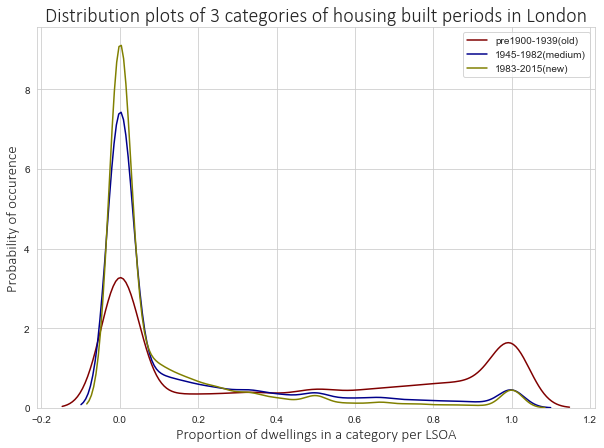

In [204]:
import numpy as np
import pandas as pd
import seaborn as sns
fig, ax = plt.subplots(figsize=(10, 7))
sns.set_style("whitegrid")
a = sns.kdeplot(gdf['pre1900-1939(old)PROP'],  color='maroon', label = 'pre1900-1939(old)', legend = True)
a = sns.kdeplot(gdf['1945-1982(medium)PROP'],   color = 'darkblue', label = '1945-1982(medium)', legend = True)
a = sns.kdeplot(gdf['1983-2015(new)PROP'],   color = 'olive', label = '1983-2015(new)', legend = True)
plt.title(label = 'Distribution plots of 3 categories of housing built periods in London', fontdict={'fontsize': '20', 'fontweight' : '3', 'family': 'Calibri'})
plt.xlabel('Proportion of dwellings in a category per LSOA', fontdict={'fontsize': '15', 'fontweight' : '3', 'family': 'Calibri'})
plt.ylabel('Probability of occurence',fontdict={'fontsize': '15', 'fontweight' : '3', 'family': 'Calibri'})
plt.legend()
plt.savefig('Distribution plots of 3 categories of housing built periods in London', dpi=300)
    

In [180]:
x = gdf['pre1900-1939(old)PROP']
y = gdf['1945-1982(medium)PROP']
z = gdf['1983-2015(new)PROP']
print(stats.kruskal(x, y, z))

import statsmodels.api as sa
import statsmodels.formula.api as sfa
import scikit_posthocs as sp
data = [x, y, z]
print(sp.posthoc_dunn(data, p_adjust = 'bonferroni'))

KruskalResult(statistic=12069.701095248565, pvalue=0.0)
     1             2             3
1  1.0  0.000000e+00  0.000000e+00
2  0.0  1.000000e+00  9.701414e-44
3  0.0  9.701414e-44  1.000000e+00


In [11]:
gdf['Labels'] = ['First Quantile' if x< 9.40  else 'Second Quantile'if 9.40<=x<11.40  else 'Third Quantile' if 11.40<=x<14.00  else 'Fourth Quantile' for x in gdf['2017']]

In [25]:
gdf.columns

Index(['lsoa11cd', 'LSOA 2001 Name', 'LA Name_x', '2009', '2010', '2011',
       'AREA_NAME_x', 'BP_PRE_1900', 'BP_1900_1918', 'BP_1919_1929',
       'BP_1930_1939', 'BP_1945_1954', 'BP_1955_1964', 'BP_1965_1972',
       'BP_1973_1982', 'BP_1983_1992', 'BP_1993_1999', 'BP_2000_2009',
       'BP_2010_2015', 'BP_UNKNOWN', 'ALL_PROPERTIES_x', 'pre1900-1939(old)',
       '1945-1982(medium)', '1983-2015(new)', 'LSOA 2011 Name', 'LA Name_y',
       '2012', '2013', '2014', '2015', '2016', '2017', 'geometry',
       'AREA_NAME_y', 'BUNGALOW', 'FLAT_MAIS', 'HOUSE_TERRACED', 'HOUSE_SEMI',
       'HOUSE_DETACHED', 'ANNEXE', 'ALL_PROPERTIES_y', 'IMD Score', 'Labels'],
      dtype='object')

In [152]:
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
labels = le.fit_transform(gdf.Labels) #so which variable needs to be encoded?  
labels

array([0, 0, 0, ..., 0, 0, 0])

In [153]:
from sklearn.model_selection import train_test_split
attributes = gdf[['pre1900-1939(old)','1945-1982(medium)', '1983-2015(new)','BUNGALOW', 'FLAT_MAIS', 'HOUSE_TERRACED', 'HOUSE_SEMI','HOUSE_DETACHED', 'ANNEXE', 'IMD Score']]
attributes = attributes.values
attributes

array([[ 60. , 900. , 130. , ...,   0. ,   0. ,   6.1],
       [ 60. , 900. , 130. , ...,   0. ,   0. ,   6.1],
       [ 60. , 900. , 130. , ...,   0. ,   0. ,   6.1],
       ...,
       [ 60. ,  10. ,  30. , ...,   0. ,   0. ,  22.4],
       [ 60. ,  10. ,  30. , ...,   0. ,   0. ,  22.4],
       [ 60. ,  10. ,  30. , ...,   0. ,   0. ,  22.4]])

In [154]:
train_d, test_d, train_lab, test_lab = train_test_split(attributes, labels)
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors= 6)  
knn.fit(train_d, train_lab)  
knn.score(attributes, labels)

0.5764995930872708

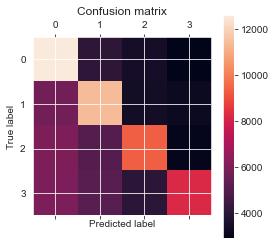

In [159]:
from sklearn import metrics
predictions = knn.predict(test_d) 
predictions
confusion_matrix = metrics.confusion_matrix(test_lab, predictions)


plt.matshow(confusion_matrix)
plt.title('Confusion matrix')
plt.colorbar()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.savefig('CONFUSION MATRIX knn', dpi=300)
plt.show()

In [34]:
from sklearn.metrics import classification_report

print (classification_report(test_lab, predictions))

              precision    recall  f1-score   support

           0       0.41      0.55      0.47     22990
           1       0.45      0.48      0.46     23990
           2       0.47      0.41      0.44     23545
           3       0.48      0.35      0.40     23476

    accuracy                           0.45     94001
   macro avg       0.45      0.45      0.44     94001
weighted avg       0.45      0.45      0.44     94001



In [13]:
gdf.columns

Index(['lsoa11cd', 'AREA_NAME_x', 'BUNGALOW', 'FLAT_MAIS', 'HOUSE_TERRACED',
       'HOUSE_SEMI', 'HOUSE_DETACHED', 'ANNEXE', 'ALL_PROPERTIES_x',
       'BUNGALOW&ANNEXE', 'HOUSE_TERRACED&HOUSE_SEMI', 'geometry', 'IMD Score',
       'LSOA 2001 Name', 'LA Name_x', '2009', '2010', '2011',
       'LSOA 2011 Name_x', 'LA Name_y', '2012', '2013', '2014', '2015', '2016',
       '2017', 'AREA_NAME_y', 'BP_PRE_1900', 'BP_1900_1918', 'BP_1919_1929',
       'BP_1930_1939', 'BP_1945_1954', 'BP_1955_1964', 'BP_1965_1972',
       'BP_1973_1982', 'BP_1983_1992', 'BP_1993_1999', 'BP_2000_2009',
       'BP_2010_2015', 'BP_UNKNOWN', 'ALL_PROPERTIES_y', 'pre1900-1939(old)',
       '1945-1982(medium)', '1983-2015(new)', 'LSOA 2011 Name_y', 'LA Name',
       'A', 'B', 'C', 'D', 'E', 'F', 'G', 'Labels'],
      dtype='object')

In [13]:
#RANDOM FOREST
feature_columns = ['pre1900-1939(old)','1945-1982(medium)', '1983-2015(new)', 'BUNGALOW&ANNEXE', 'FLAT_MAIS', 'HOUSE_TERRACED', 'HOUSE_TERRACED&HOUSE_SEMI',  'IMD Score', 'A', 'B', 'C', 'D', 'E', 'F', 'G']
class_column = 'Labels'

data_features = gdf[feature_columns].values
data_classes = gdf[class_column].values

In [14]:
from sklearn.model_selection import train_test_split
from time import time
from sklearn.ensemble import RandomForestClassifier
train_d, test_d, train_lab, test_lab = train_test_split(data_features, data_classes)

t0 = time() # adding a time() function here, so we know how many minutes has been used

clf = RandomForestClassifier(n_estimators=128, n_jobs=-1)
clf.fit(train_d, train_lab)

print("done in %0.3fs." % (time() - t0))
print(clf.score(test_d, test_lab))

done in 16.890s.
0.9584791651152648


In [18]:
from sklearn.model_selection import StratifiedShuffleSplit
test_data_size = 0.2

cross_validation = StratifiedShuffleSplit(n_splits=10,test_size=test_data_size, random_state=0)
cross_validation

StratifiedShuffleSplit(n_splits=10, random_state=0, test_size=0.2,
            train_size=None)

In [19]:
group_index = 1
for train_index, test_index in cross_validation.split(data_features, data_classes):
    data_features_train, data_classes_train = data_features[train_index], data_classes[train_index]
    data_features_test, data_classes_test = data_features[test_index], data_classes[test_index]
    print ('sub group %d' %group_index)
    print ('number of traning recrods is: %d' %len(data_features_train))
    print ('number of testing recrods is: %d' %len(data_features_test))
    group_index = group_index +1

sub group 1
number of traning recrods is: 300801
number of testing recrods is: 75201
sub group 2
number of traning recrods is: 300801
number of testing recrods is: 75201
sub group 3
number of traning recrods is: 300801
number of testing recrods is: 75201
sub group 4
number of traning recrods is: 300801
number of testing recrods is: 75201
sub group 5
number of traning recrods is: 300801
number of testing recrods is: 75201
sub group 6
number of traning recrods is: 300801
number of testing recrods is: 75201
sub group 7
number of traning recrods is: 300801
number of testing recrods is: 75201
sub group 8
number of traning recrods is: 300801
number of testing recrods is: 75201
sub group 9
number of traning recrods is: 300801
number of testing recrods is: 75201
sub group 10
number of traning recrods is: 300801
number of testing recrods is: 75201


In [20]:
from sklearn.metrics import confusion_matrix, precision_recall_curve, roc_curve, auc
from sklearn.metrics import confusion_matrix
scores = []
confusion_matrices = []
precision_scores = {}
recall_scores = {}
pr_auc_scores = {}
fpr_scores = {}
tpr_scores = {}
roc_auc_scores = {}

for train_index, test_index in cross_validation.split(data_features, data_classes):
    data_features_train, data_classes_train = data_features[train_index], data_classes[train_index]
    data_features_test, data_classes_test = data_features[test_index], data_classes[test_index]
    
    '''
    You need a bit more than 8GB RAM for predicting 2 classes with 256 trees.
    Of course, you can use a lower number, but gradually you'll notice worse performance.
    '''
    
    # write your code here - initiate the model and then fit the model with training data set
    # do not panic, you have written the code before already
    
    clf = RandomForestClassifier(n_estimators=128, n_jobs=-1)
    clf.fit(data_features_train, data_classes_train)
 
    # calcuating and Saving the scores.
    test_score = clf.score(data_features_test, data_classes_test)
    scores.append(test_score)
    
    # Saving the confusion matrices.
    data_classes_pred = clf.predict(data_features_test)
    cm = confusion_matrix( data_classes_test, data_classes_pred)
    confusion_matrices.append(cm)
    
    # Saving the necesary data for the P/R and the ROC scores.
    prob = clf.predict_proba(data_features_test)
    
      # then we calculate kinds of scores for measuring the performance
    if not pr_auc_scores:
        for c in clf.classes_:
            precision_scores[c] = []
            recall_scores[c] = []
            pr_auc_scores[c] = []
            fpr_scores[c] = []
            tpr_scores[c] = []
            roc_auc_scores[c] = []
            
    
    for c in clf.classes_:
        prob_index = np.where(clf.classes_ == c)[0][0]
        
        precision, recall, _ = precision_recall_curve(data_classes_test, prob[:, prob_index], pos_label=c)
        precision_scores[c].append(precision)
        recall_scores[c].append(recall)
        pr_auc_scores[c].append(auc(recall, precision))

        fpr, tpr, _ = roc_curve(data_classes_test, prob[:, prob_index], pos_label=c)
        fpr_scores[c].append(fpr)
        tpr_scores[c].append(tpr)
        roc_auc_scores[c].append(auc(fpr, tpr))

print ('Accuracy mean: ' + str(np.mean(scores)))
print ('Accuracy std: ' + str(np.std(scores)))

Accuracy mean: 0.9616401377641255
Accuracy std: 0.0009068804106613514


In [26]:
classes = ['', 'First Quantile', 'Second Quantile']
sns.set_style("darkgrid")
def plot_auc(a_scores, b_scores, auc_scores, messages):
    
    # First axis.
    
    a_scores_copy = {}
    a_scores_avg = {}
    
    max_length = 0
    
    for a in a_scores[classes[1]] + a_scores[classes[2]]:
        length = len(a)
        if length > max_length:
            max_length = length
    
    for c in classes[1:]:
        a_scores_copy[c] = []
        
        for a in a_scores[c]:
            length = len(a)
            
            if length < max_length:
                for i in range(length, max_length):
                    a = np.append(a, a[length - 1])
        
            a_scores_copy[c].append(a)
                
        a_scores_avg[c] = np.average(np.array(a_scores_copy[c]), axis=0)

    # Second axis.

    b_scores_copy = {}
    b_scores_avg = {}

    for c in classes[1:]:
        b_scores_copy[c] = []
        
        for b in b_scores[c]:
            length = len(b)
            
            if length < max_length:
                for i in range(length, max_length):
                    b = np.append(b, b[length - 1])
            
            b_scores_copy[c].append(b)
        
        b_scores_avg[c] = np.average(np.array(b_scores_copy[c]), axis=0)

    # Plotting.

    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    i = 0

    for c in classes[1:]:
        a = a_scores_avg[c]
        b = b_scores_avg[c]
        auc_score = np.mean(auc_scores[c])

        if messages['title'] == 'ROC':
            ax[i].plot([0, 1], [0, 1], 'k--')
            ax[i].plot(a, b)
        else:
            ax[i].plot(b, a)

        ax[i].set_xlim([0.0, 1.0])
        ax[i].set_ylim([0.0, 1.0])
        
        if messages['title'] == 'ROC':
            ax[i].fill_between(a, b, alpha=0.5)
        else:
            ax[i].fill_between(b, a, alpha=0.5)
            
        ax[i].set_title(messages['title'] + ' curve (AUC = %0.2f) | Class "%s"' % (auc_score, c), fontsize=15)
        ax[i].set_xlabel(messages['x_label'], fontsize=15)
        ax[i].set_ylabel(messages['y_label'], fontsize=15)
        
        ax[i].tick_params(labelsize=12)
        
        i += 1

    fig.tight_layout()

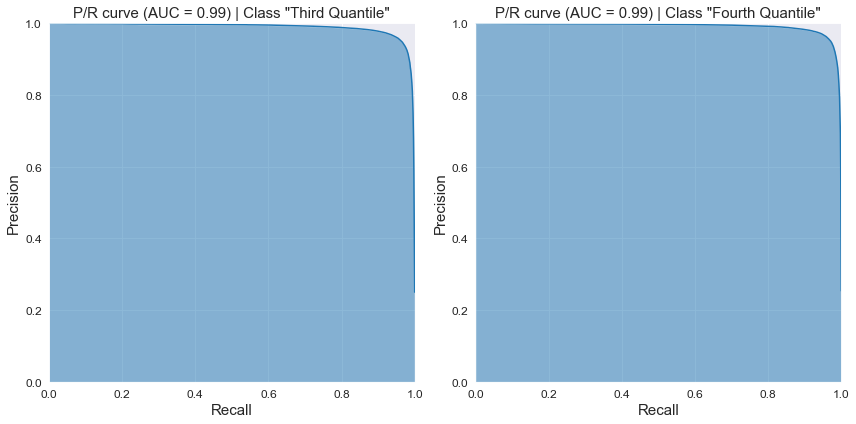

In [24]:
messages = {'title': 'P/R', 'x_label': 'Recall', 'y_label': 'Precision'}
plot_auc(precision_scores, recall_scores, pr_auc_scores, messages)


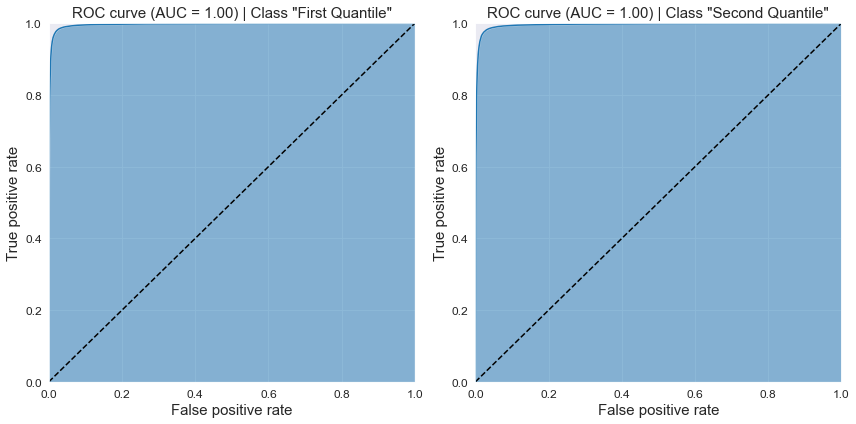

In [27]:
messages = {'title': 'ROC', 'x_label': 'False positive rate', 'y_label': 'True positive rate'}
plot_auc(fpr_scores, tpr_scores, roc_auc_scores, messages)

In [28]:
classes

['', 'First Quantile', 'Second Quantile']

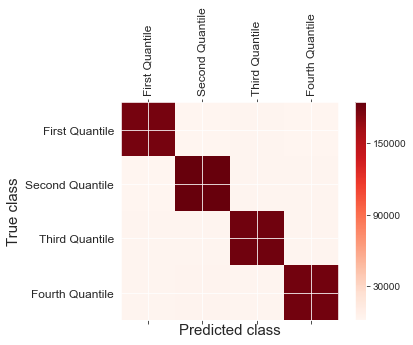

In [35]:
classes = ['', 'First Quantile', 'Second Quantile', 'Third Quantile', 'Fourth Quantile']
from matplotlib import cm as cmap
first = True
cm = None

for cm_iter in confusion_matrices:
    if first:
        cm = cm_iter.copy()
        first = False
    else:
        cm = cm + cm_iter

fig, ax = plt.subplots()

colorbar = ax.matshow(cm, cmap=cmap.Reds)
fig.colorbar(colorbar, ticks=[30000, 90000, 150000, 210000, 270000, 330000, 390000])

ax.set_xlabel('Predicted class', fontsize=15)
ax.set_ylabel('True class', fontsize=15)

ax.set_xticklabels(classes, rotation=90)
ax.set_yticklabels(classes)

ax.tick_params(labelsize=12)
plt.savefig('Confusion Matrix', dpi=300)

In [45]:
gdf['data_classes_pred'] = clf.predict(data_features)
print(len(gdf['data_classes_pred']))
print(len(gdf['Labels']))

gdf['data_classes_pred'] == gdf['Labels']
gdf['Correct_False'] = np.where(gdf['data_classes_pred'] == gdf['Labels'], 'Correct', 'Incorrect')

376002
376002


In [47]:
gdf['Correct_False'].unique()

array(['Correct', 'Incorrect'], dtype=object)

<Figure size 720x576 with 0 Axes>

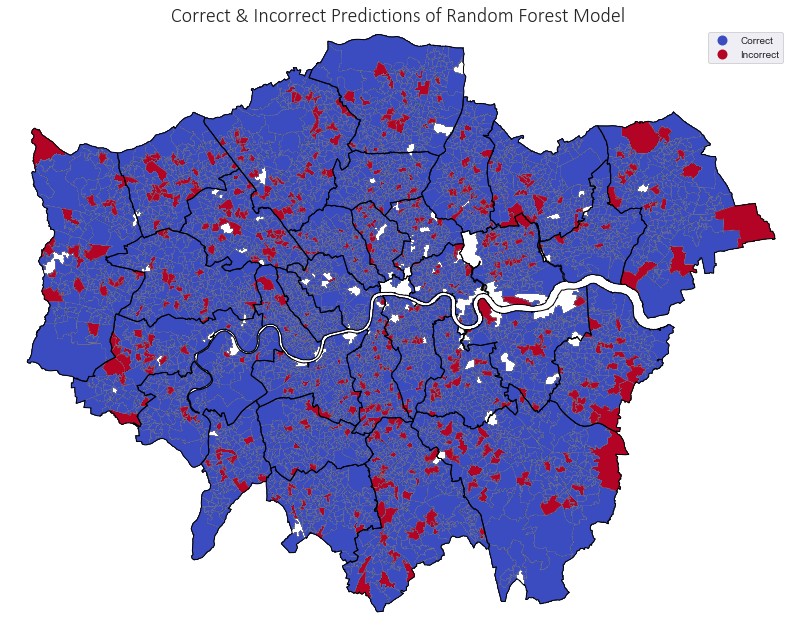

In [55]:
fig = plt.figure(figsize=(10, 8))
fig, ax = plt_ldn()
gdf.plot(column='Correct_False',  legend=True, ax=ax, edgecolor='grey', linewidth=0.2, cmap = 'coolwarm') 
ax.axis('off') 
ax.set_title('Correct & Incorrect Predictions of Random Forest Model', fontdict={'fontsize': '20', 'fontweight' : '3', 'family': 'Calibri'}), #provide a title
leg = ax.get_legend()
plt.savefig("Correct & Incorrect Predictions of Random Forest Model")
plt.show()

In [57]:
gdf.columns

Index(['lsoa11cd', 'AREA_NAME_x', 'BUNGALOW', 'FLAT_MAIS', 'HOUSE_TERRACED',
       'HOUSE_SEMI', 'HOUSE_DETACHED', 'ANNEXE', 'ALL_PROPERTIES_x',
       'BUNGALOW&ANNEXE', 'HOUSE_TERRACED&HOUSE_SEMI', 'geometry', 'IMD Score',
       'LSOA 2001 Name', 'LA Name_x', '2009', '2010', '2011',
       'LSOA 2011 Name_x', 'LA Name_y', '2012', '2013', '2014', '2015', '2016',
       '2017', 'AREA_NAME_y', 'BP_PRE_1900', 'BP_1900_1918', 'BP_1919_1929',
       'BP_1930_1939', 'BP_1945_1954', 'BP_1955_1964', 'BP_1965_1972',
       'BP_1973_1982', 'BP_1983_1992', 'BP_1993_1999', 'BP_2000_2009',
       'BP_2010_2015', 'BP_UNKNOWN', 'ALL_PROPERTIES_y', 'pre1900-1939(old)',
       '1945-1982(medium)', '1983-2015(new)', 'LSOA 2011 Name_y', 'LA Name',
       'A', 'B', 'C', 'D', 'E', 'F', 'G', 'Labels', 'data_classes_pred',
       'Correct_False'],
      dtype='object')

In [ ]:
import matplotlib.pyplot as plt
from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from sklearn.multiclass import OneVsRestClassifier


feature_columns = ['pre1900-1939(old)','1945-1982(medium)', '1983-2015(new)', 'BUNGALOW&ANNEXE', 'FLAT_MAIS', 'HOUSE_TERRACED&HOUSE_SEMI',  'IMD Score', 'A', 'B', 'C', 'D', 'E', 'F', 'G']
class_column = 'Labels'
X = gdf[feature_columns].values
y = gdf[class_column].values

# Binarize the output
y = label_binarize(y, classes=['First Quantile', 'Second Quantile', 'Third Quantile', 'Fourth Quantile'])
n_classes = y.shape[1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.5, random_state=0)

classifier = OneVsRestClassifier(svm.SVC(kernel='linear', probability=True,
                                 random_state=0))
y_score = classifier.fit(X_train, y_train).decision_function(X_test)

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
colors = ['blue', 'red', 'green', 'yellow']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, 
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for multi-class data')
plt.legend(loc="lower right")
plt.show()

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from sklearn.metrics import roc_auc_score

# Import some data to play with
feature_columns = ['pre1900-1939(old)','1945-1982(medium)', '1983-2015(new)', 'BUNGALOW&ANNEXE', 'FLAT_MAIS', 'HOUSE_TERRACED', 'HOUSE_TERRACED&HOUSE_SEMI',  'IMD Score', 'A', 'B', 'C', 'D', 'E', 'F', 'G']
class_column = 'Labels'
X = gdf[feature_columns].values
y = gdf[class_column].values

# Binarize the output
y = label_binarize(y, classes=[ 'First Quantile', 'Second Quantile', 'Third Quantile', 'Fourth Quantile'])
n_classes = y.shape[1]

# Add noisy features to make the problem harder
random_state = np.random.RandomState(0)
n_samples, n_features = X.shape
X = np.c_[X, random_state.randn(n_samples, 200 * n_features)]

# shuffle and split training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.5,
                                                    random_state=0)

# Learn to predict each class against the other
classifier = OneVsRestClassifier(svm.SVC(kernel='linear', probability=True,
                                 random_state=random_state))
y_score = classifier.fit(X_train, y_train).decision_function(X_test)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])


plt.figure()
lw = 2
plt.plot(fpr[2], tpr[2], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[2])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

NameError: name 'gdf' is not defined

In [ ]:
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'black'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()